<a href="https://colab.research.google.com/github/liangChen1209/Explore-COVID_19/blob/master/COVID_19_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from tqdm import tqdm
import os
import cv2
import copy
from PIL import Image
from google.colab import drive
from google_drive_downloader import GoogleDriveDownloader as gdd
from google.colab.patches import cv2_imshow
from datetime import datetime
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LinearRegression,Ridge, Lasso, ElasticNet, BayesianRidge,ARDRegression,HuberRegressor
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Link for the dataset:

https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data

## Part I - Visualization of interesting insights

Read dataset from the raw data

In [0]:
url_confirmed_global = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'

url_deaths_global = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'

url_recovered_global = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'


confirmed_global = pd.read_csv(url_confirmed_global,error_bad_lines=False)
deaths_global = pd.read_csv(url_deaths_global,error_bad_lines=False)
recovered_global  = pd.read_csv(url_recovered_global,error_bad_lines=False)

Define a function which can automatically check how many null values in a given column of a given dataframe

In [0]:
def check_null(dataframe):
  cols = dataframe.keys()
  null_values={}
  for col in cols:
    num = 0
    lst_of_bools = dataframe[col].isnull()
    for bool in lst_of_bools:
      if bool==True:
        num+=1
    null_values[col] = num
  
  return pd.DataFrame(null_values,index=['nums of NaNs'])

Define a function which explores data by countries and dates. The returned dataframe should be a map in which the dates are the keys and the countries' maps are the values.

The countries maps are maps in which each country is the key and the number of interest for each country is the value. The number of interest may include: number of global confirmed cases , number of global death cases, number of global recovered cases.

The returned dataframe is hierarchical in nature.



In [0]:
def Explore_cases_by_countries_and_dates(dataframe):
  dates = dataframe.keys()[3:]
  countries = sorted(dataframe['Country/Region'].unique())
  date_to_countries={} # key is the date, value is the dict "countries_to_cases_per_day"
  countries_to_cases_per_day={} # key is the country, value is the cases
  for country in countries:
    countries_to_cases_per_day[country] = 0

  for date in dates:
    # For some countries, they have multiple rows for different long/lat 
    # We count cases as a whole country
    cases_per_day = dataframe.groupby(by='Country/Region').agg({date:'sum'})
    cases =  list(cases_per_day[date])
    countries_to_cases_per_day={}
    for country in countries:
      countries_to_cases_per_day[country] = 0
    for i in range(len(countries)):
      countries_to_cases_per_day[countries[i]] = cases[i] 
    date_to_countries[date] = countries_to_cases_per_day

  return date_to_countries

### Exploratory Data Analysis (EDA)

Check the null values in the given dataframes

In [0]:
check_null(confirmed_global)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20
nums of NaNs,184,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
check_null(deaths_global)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20
nums of NaNs,184,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
check_null(recovered_global)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20
nums of NaNs,185,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Since "province/state" column has many nan values and is not particularly useful in our analysis, we drop this column. Same for global death cases and global revcovered cases analyzed later.

In [0]:
confirmed_global = confirmed_global.drop(columns=['Province/State'])

In [0]:
deaths_global = deaths_global.drop(columns=['Province/State'])

In [0]:
recovered_global = recovered_global.drop(columns=['Province/State'])

### Explore global confirmed cases

In [0]:
confirmed_global

,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,...,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20
0,Afghanistan,33.000000,65.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,...,110,110,120,170,174,237,273,281,299,349,367,423,444,484,521,555,607,665,714,784,840,906,933,996,1026,1092,1176,1279,1351,1463,1531,1703,1828,1939,2171,2335,2469,2704,2894,3224
1,Albania,41.153300,20.168300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,186,197,212,223,243,259,277,304,333,361,377,383,400,409,416,433,446,467,475,494,518,539,548,562,584,609,634,663,678,712,726,736,750,766,773,782,789,795,803,820
2,Algeria,28.033900,1.659600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,...,409,454,511,584,716,847,986,1171,1251,1320,1423,1468,1572,1666,1761,1825,1914,1983,2070,2160,2268,2418,2534,2629,2718,2811,2910,3007,3127,3256,3382,3517,3649,3848,4006,4154,4295,4474,4648,4838
3,Andorra,42.506300,1.521800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,267,308,334,370,376,390,428,439,466,501,525,545,564,583,601,601,638,646,659,673,673,696,704,713,717,717,723,723,731,738,738,743,743,743,745,745,747,748,750,751
4,Angola,-11.202700,17.873900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,4,5,7,7,7,8,8,8,10,14,16,17,19,19,19,19,19,19,19,19,19,19,24,24,24,24,25,25,25,25,26,27,27,27,27,30,35,35,35,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,Western Sahara,24.215500,-12.885800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4,4,4,4,4,4,4,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6
262,Sao Tome and Principe,0.186360,6.613081,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,8,8,14,16,16,16,23,174
263,Yemen,15.552727,48.516388,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,6,6,7,10,10,12,22
264,Comoros,-11.645500,43.333300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,3,3,3,3


From the dataset, we can observe that the number of deaths cases is cumulative by date for every country.

Explores the dataset by countries and dates.

In [0]:
# Make a deep copy of the returned dictionary when exploring the dataset by countries and dates.
confirmed_cases = copy.deepcopy(Explore_cases_by_countries_and_dates(confirmed_global))

What are the top 10 countries that have the most confirmed cases up to date?

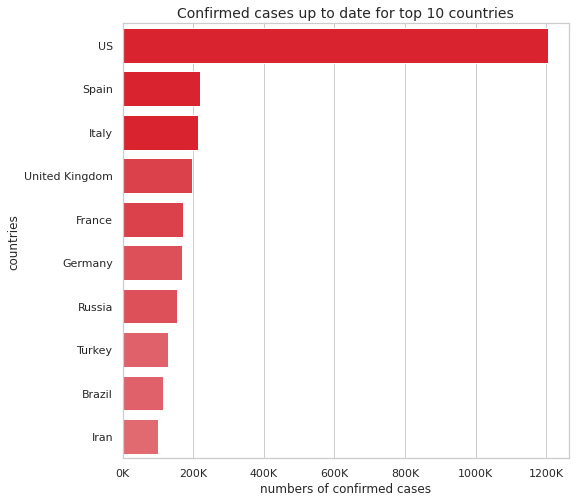

In [0]:
countries_top10=[]
confirmed_top10=[]
latest_day = confirmed_global.keys()[-1]
for tup in sorted(confirmed_cases[latest_day].items(),key=lambda x: x[1],reverse=True)[:10]:
  countries_top10.append(tup[0])
  confirmed_top10.append(tup[1])
c = ['#f70514','#f70514','#f70514','#f52734','#f52734','#f53844','#f53844','#f54c57','#f54c57','#f55660']
sns.set(style='whitegrid',palette=c,rc={'figure.figsize':(8,8)})
g = sns.barplot(confirmed_top10,countries_top10)
title='Confirmed cases up to date for top 10 countries'
x_labels = [str(int(x)) + 'K' for x in g.get_xticks()/1000]
g.set_xticklabels(x_labels,fontdict={'fontsize':11})
g.set_yticklabels(g.get_yticklabels(),fontdict={'fontsize':11})
g.set_xlabel('numbers of confirmed cases',fontdict={'fontsize':12})
g.set_ylabel('countries',fontdict={'fontsize':12})
g_title_text = g.set_title(title,fontdict={'fontsize':14})

Visualize the confirmed cases since 1/22/2020 for US, Italy, Spain, France and Germany.

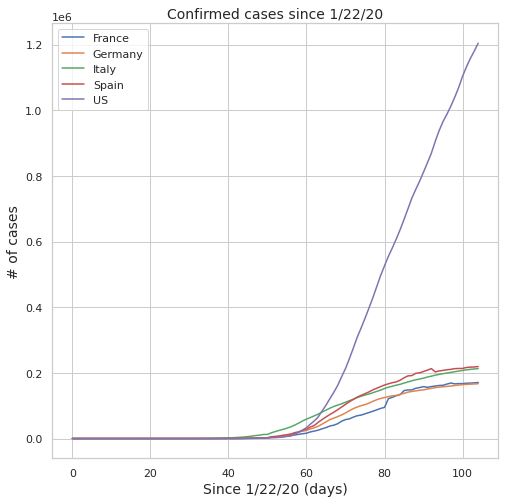

In [0]:
# Calculate the duration between 1/22/2020 and the latest record in the dataset
duration = (datetime.strptime(confirmed_global.keys()[-1],'%m/%d/%y') \
            - datetime.strptime(confirmed_global.keys()[3],'%m/%d/%y')).days
aggrn = {}
for date in confirmed_global.keys()[3:]:
  aggrn[date]='sum'
# Do summation of confirmed cases for each country
confirmed_by_countries = confirmed_global.groupby(by='Country/Region').agg(aggrn).reset_index()

y_us = list(confirmed_by_countries[confirmed_by_countries['Country/Region']=='US'].iloc[0])[1:]
y_italy = list(confirmed_by_countries[confirmed_by_countries['Country/Region']=='Italy'].iloc[0])[1:]
y_spain = list(confirmed_by_countries[confirmed_by_countries['Country/Region']=='Spain'].iloc[0])[1:]
y_france = list(confirmed_by_countries[confirmed_by_countries['Country/Region']=='France'].iloc[0])[1:]
y_germany = list(confirmed_by_countries[confirmed_by_countries['Country/Region']=='Germany'].iloc[0])[1:]

sns.set(style='whitegrid',rc={'figure.figsize':(8,8),'xtick.labelsize':11,'ytick.labelsize':11})
g = sns.lineplot(range(duration+1),y_france)
g = sns.lineplot(range(duration+1),y_germany)
g = sns.lineplot(range(duration+1),y_italy)
g = sns.lineplot(range(duration+1),y_spain)
g = sns.lineplot(range(duration+1),y_us)

title='Confirmed cases since 1/22/20'
g.set_xlabel('Since 1/22/20 (days)',fontdict={'fontsize':14})
g.set_ylabel('# of cases',fontdict={'fontsize':14})
g_title_text = g.set_title(title,fontdict={'fontsize':14})
g.legend(['France','Germany','Italy','Spain','US'])
plt.show()

### Explore global death cases

From the dataset, we can observe that the number of deaths cases is cumulative by date for every country.

Explores the dataset by countries and dates.

In [0]:
# Make a deep copy of the returned dictionary when exploring the dataset by countries and dates.
deaths_cases = copy.deepcopy(Explore_cases_by_countries_and_dates(deaths_global))

In [0]:
deaths_global

,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,...,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20
0,Afghanistan,33.000000,65.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,4,4,4,4,4,4,6,6,7,7,11,14,14,15,15,18,18,21,23,25,30,30,30,33,36,36,40,42,43,47,50,57,58,60,64,68,72,85,90,95
1,Albania,41.153300,20.168300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,8,10,10,11,15,15,16,17,20,20,21,22,22,23,23,23,23,23,24,25,26,26,26,26,26,26,27,27,27,27,28,28,30,30,31,31,31,31,31,31
2,Algeria,28.033900,1.659600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,26,29,31,35,44,58,86,105,130,152,173,193,205,235,256,275,293,313,326,336,348,364,367,375,384,392,402,407,415,419,425,432,437,444,450,453,459,463,465,470
3,Andorra,42.506300,1.521800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,3,3,6,8,12,14,15,16,17,18,21,22,23,25,26,26,29,29,31,33,33,35,35,36,37,37,37,37,40,40,40,40,41,42,42,43,44,45,45,46
4,Angola,-11.202700,17.873900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,Western Sahara,24.215500,-12.885800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
262,Sao Tome and Principe,0.186360,6.613081,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,3,3
263,Yemen,15.552727,48.516388,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,2,2,4
264,Comoros,-11.645500,43.333300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


What are the top 10 countries that have the most death cases up to date?

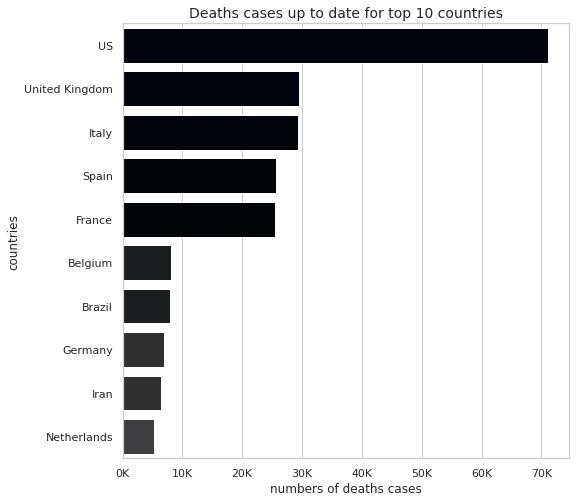

In [0]:
countries_top10=[]
deaths_top10=[]
latest_day = confirmed_global.keys()[-1]
for tup in sorted(deaths_cases[latest_day].items(),key=lambda x: x[1],reverse=True)[:10]:
  countries_top10.append(tup[0])
  deaths_top10.append(tup[1])
c=['#01030d','#02040d','#02040a','#020308','#020308','#1c1d1f','#1c1d1f','#2f2f30','#2f2f30','#3e3e40']
sns.set(style='whitegrid',palette=c,rc={'figure.figsize':(8,8)})
g = sns.barplot(deaths_top10,countries_top10)
title='Deaths cases up to date for top 10 countries'
x_labels = [str(int(x)) + 'K' for x in g.get_xticks()/1000]
g.set_xticklabels(x_labels,fontdict={'fontsize':11})
g.set_yticklabels(g.get_yticklabels(),fontdict={'fontsize':11})
g.set_xlabel('numbers of deaths cases',fontdict={'fontsize':12})
g.set_ylabel('countries',fontdict={'fontsize':12})
g_title_text = g.set_title(title,fontdict={'fontsize':14})

### Explore global recovered cases

From the dataset, we can observe that the number of recovered cases is cumulative by date for every country.

Explores the dataset by countries and dates.

In [0]:
recovered_cases = copy.deepcopy(Explore_cases_by_countries_and_dates(recovered_global))

In [0]:
recovered_global

,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,...,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20
0,Afghanistan,33.000000,65.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2,2,2,2,5,5,10,10,10,15,18,18,29,32,32,32,32,32,40,43,54,99,112,131,135,150,166,179,188,188,207,220,228,252,260,310,331,345,397,421
1,Albania,41.153300,20.168300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,31,31,33,44,52,67,76,89,99,104,116,131,154,165,182,197,217,232,248,251,277,283,302,314,327,345,356,385,394,403,410,422,431,455,470,488,519,531,543,570
2,Algeria,28.033900,1.659600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,29,31,31,37,46,61,61,62,90,90,90,113,237,347,405,460,591,601,691,708,783,846,894,1047,1099,1152,1204,1355,1408,1479,1508,1558,1651,1702,1779,1821,1872,1936,1998,2067
3,Andorra,42.506300,1.521800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,1,10,10,10,10,16,21,26,31,39,52,58,71,71,128,128,128,169,169,191,205,235,248,282,309,333,344,344,344,385,398,423,468,468,472,493,499,514
4,Angola,-11.202700,17.873900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,1,1,2,2,2,2,2,2,2,4,4,4,5,5,5,5,6,6,6,6,6,6,6,6,6,6,6,7,7,11,11,11,11,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,Western Sahara,24.215500,-12.885800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,5,5,5,5,5,5,5,5,5,5,5,5
248,Sao Tome and Principe,0.186360,6.613081,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,4,4,4,4,4,4,4
249,Yemen,15.552727,48.516388,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1
250,Comoros,-11.645500,43.333300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


What are the top 10 countries that have the most recovered cases up to date?

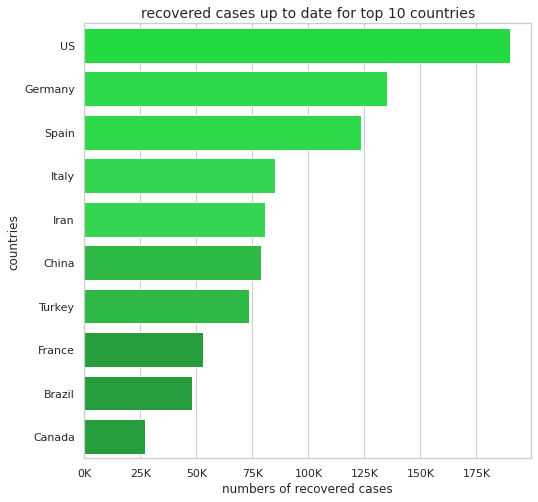

In [0]:
countries_top10=[]
recovered_top10=[]
latest_day = confirmed_global.keys()[-1]
for tup in sorted(recovered_cases[latest_day].items(),key=lambda x: x[1],reverse=True)[:10]:
  countries_top10.append(tup[0])
  recovered_top10.append(tup[1])
c=['#07f72f','#11f738','#11f738','#1af03f','#1af03f','#17cf37','#17cf37','#13b02f','#13b02f','#13b02f']
sns.set(style='whitegrid',palette=c,rc={'figure.figsize':(8,8)})
g = sns.barplot(recovered_top10,countries_top10)
title='recovered cases up to date for top 10 countries'
x_labels = [str(int(x)) + 'K' for x in g.get_xticks()/1000]
g.set_xticklabels(x_labels,fontdict={'fontsize':11})
g.set_yticklabels(g.get_yticklabels(),fontdict={'fontsize':11})
g.set_xlabel('numbers of recovered cases',fontdict={'fontsize':12})
g.set_ylabel('countries',fontdict={'fontsize':12})
g_title_text = g.set_title(title,fontdict={'fontsize':14})

### Explore mortality rate and recovery rate

Let's see the respective mortality rate and recovery rate among the top10 countries in terms of the confirmed cases. 

Explore mortality rate

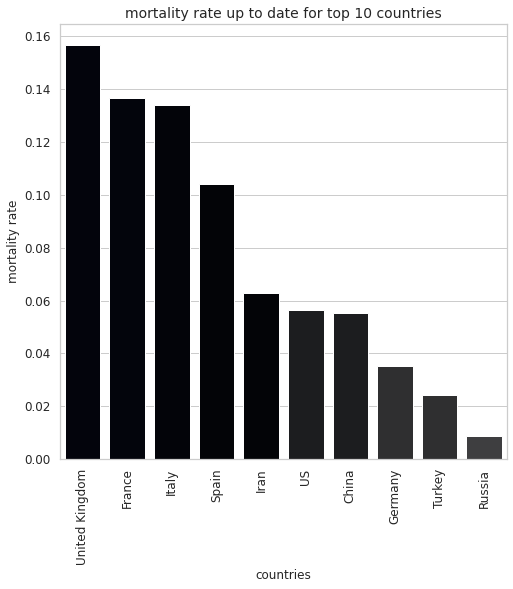

In [0]:
confirmed_top10 = sorted(confirmed_cases['4/22/20'].items(),key=lambda x: x[1],reverse=True)[:10]
countries_to_mortalities={}
countries_mortality=[]
mortalities=[]
for country, confirm_num in confirmed_top10:
  deaths = deaths_cases['4/22/20'][country]
  mortality_rate = deaths/confirm_num
  countries_to_mortalities[country] = mortality_rate

for tup in sorted(countries_to_mortalities.items(),key=lambda x: x[1],reverse=True):
  countries_mortality.append(tup[0])
  mortalities.append(tup[1])

c=['#01030d','#02040d','#02040a','#020308','#020308','#1c1d1f','#1c1d1f','#2f2f30','#2f2f30','#3e3e40']
sns.set(style='whitegrid',palette=c,rc={'figure.figsize':(8,8),'xtick.labelsize':12,'ytick.labelsize':12})
g = sns.barplot(countries_mortality,mortalities)
title='mortality rate up to date for top 10 countries'
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set_xlabel('countries',fontdict={'fontsize':12})
g.set_ylabel('mortality rate',fontdict={'fontsize':12})
g_title_text = g.set_title(title,fontdict={'fontsize':14})

Explore recovery rate

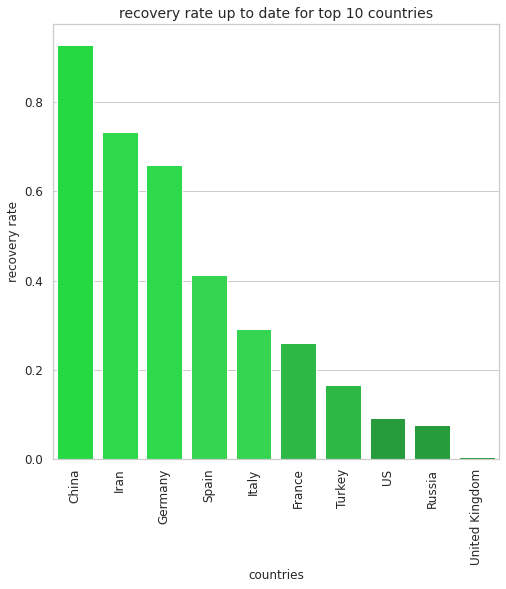

In [0]:
confirmed_top10 = sorted(confirmed_cases['4/22/20'].items(),key=lambda x: x[1],reverse=True)[:10]
countries_to_recovery={}
countries_recovery=[]
recovery=[]
for country, confirm_num in confirmed_top10:
  recovery_num = recovered_cases['4/22/20'][country]
  recovery_rate = recovery_num/confirm_num
  countries_to_recovery[country] = recovery_rate

for tup in sorted(countries_to_recovery.items(),key=lambda x: x[1],reverse=True):
  countries_recovery.append(tup[0])
  recovery.append(tup[1])

c=['#07f72f','#11f738','#11f738','#1af03f','#1af03f','#17cf37','#17cf37','#13b02f','#13b02f','#13b02f']
sns.set(style='whitegrid',palette=c,rc={'figure.figsize':(8,8),'xtick.labelsize':12,'ytick.labelsize':12})
g = sns.barplot(countries_recovery,recovery)
title='recovery rate up to date for top 10 countries'
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set_xlabel('countries',fontdict={'fontsize':12})
g.set_ylabel('recovery rate',fontdict={'fontsize':12})
g_title_text = g.set_title(title,fontdict={'fontsize':14})

## Part II - Explore different regression techniques for predicting confirmed cases within US in the next 10 days 

In [0]:
confirmed_US = confirmed_by_countries[confirmed_by_countries['Country/Region']=='US']
confirmed_US

,Country/Region,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,...,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20
173,US,1,1,2,2,5,5,5,5,5,7,8,8,11,11,11,11,11,11,11,11,12,12,13,13,13,13,13,13,13,13,15,15,15,51,51,57,58,60,68,...,101657,121465,140909,161831,188172,213242,243622,275367,308650,336802,366317,397121,428654,462780,496535,526396,555313,580619,607670,636350,667592,699706,732197,758809,784326,811865,840351,869170,905358,938154,965785,988197,1012582,1039909,1069424,1103461,1132539,1158040,1180375,1204351


In [0]:
# Set X and y for training
X_days = np.array(range(len(confirmed_US.keys()[1:])))
y_confirmed_num_US = [int(confirmed_US[key].values) for key in confirmed_US.keys()[1:]]

In [0]:
# Generate train and test datasets respectively
x_train_US,x_test_US,y_train_US,y_test_US = train_test_split(X_days,y_confirmed_num_US,train_size=0.9,test_size=0.1,shuffle=False)

In [0]:
# Rescale the shape of the datasets to a higher dimension
x_train_US = x_train_US[:,None]
x_test_US = x_test_US[:,None]

### Linear Regression

Explore different degrees of polynomials used for prediction. Decide the degree that fit the data most by evaluating the Root Mean Square Error between the prediction values and the true values, using the test dataset.

The upper six plots show the prediction values and true values of training dataset. 

The lower six plots show the prediction values and true values of test dataset. 

We can observe that as the degree of polynomial increases, the predicted curve and the true curve of training dataset become closer and closer, whereas the predicted curve and the true curve of test dataset first become closer, then diverge (as shown in printed RMSE errors). 

**This reflect that as degree of polynomial becomes too large, the model will become overfitting. We also cannot choose a degree of polynomial that is too small because the model will be underfitting in that case. Therefore, we choose the model which yields the lowest RMSE error.**

Respectively, RMSE errors from first degree to six degree are:  
 520637.9935448451 
 58242.543329365675 
 244152.66421188816 
 192840.17803043916 
 132972.97587798344 
 364683.4976700886


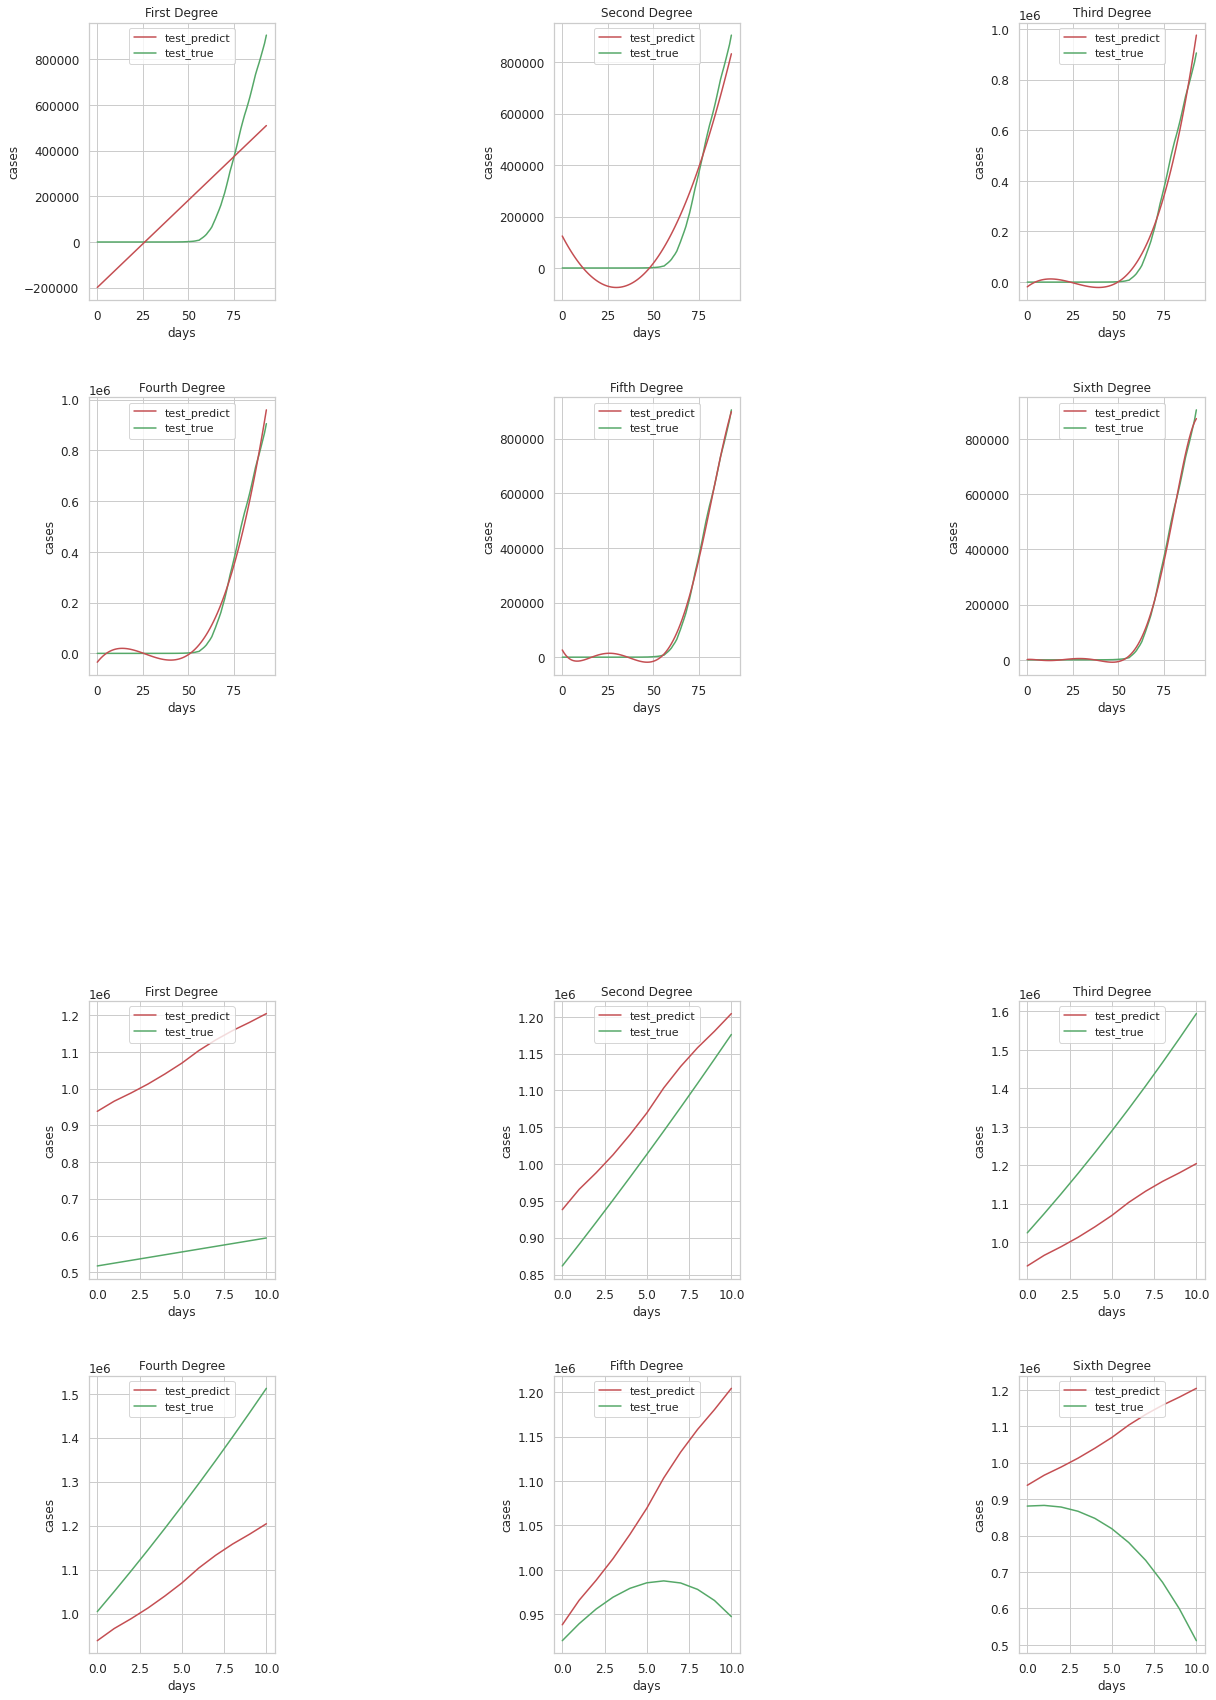

In [0]:
fig = plt.figure(figsize=(20, 30))
outer = gridspec.GridSpec(2, 1, wspace=0.2, hspace=0.5)

inner = gridspec.GridSpecFromSubplotSpec(2, 3, subplot_spec=outer[0], wspace=1.5, hspace=0.35)
#model1
poly_1 = PolynomialFeatures(1,interaction_only=False,include_bias=True)
# transform data into five-dimensional data (include a term for bias)
x_train_US_transformed_1 = poly_1.fit_transform(x_train_US)
x_test_US_transformed_1 = poly_1.fit_transform(x_test_US)
#Train polynomial linear regression model
model1 = LinearRegression(normalize=False).fit(x_train_US_transformed_1,y_train_US)
ax = plt.Subplot(fig,inner[0])
ax.plot(y_train_US,'g-',label='train_true')
ax.plot(model1.predict(x_train_US_transformed_1),'r-',label='train_predict')
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('First Degree')
ax.legend(handles, labels, loc='upper center')
fig.add_subplot(ax)
#model2
poly_2 = PolynomialFeatures(2,interaction_only=False,include_bias=True)
# transform data into five-dimensional data (include a term for bias)
x_train_US_transformed_2 = poly_2.fit_transform(x_train_US)
x_test_US_transformed_2 = poly_2.fit_transform(x_test_US)
#Train polynomial linear regression model
model2 = LinearRegression(normalize=False).fit(x_train_US_transformed_2,y_train_US)
ax = plt.Subplot(fig,inner[1])
ax.plot(y_train_US,'g-',label='train_true')
ax.plot(model2.predict(x_train_US_transformed_2),'r-',label='train_predict')
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Second Degree')
ax.legend(handles, labels, loc='upper center')
fig.add_subplot(ax)
#model3
poly_3 = PolynomialFeatures(3,interaction_only=False,include_bias=True)
# transform data into five-dimensional data (include a term for bias)
x_train_US_transformed_3 = poly_3.fit_transform(x_train_US)
x_test_US_transformed_3 = poly_3.fit_transform(x_test_US)
#Train polynomial linear regression model
model3 = LinearRegression(normalize=False).fit(x_train_US_transformed_3,y_train_US)
ax = plt.Subplot(fig,inner[2])
ax.plot(y_train_US,'g-',label='train_true')
ax.plot(model3.predict(x_train_US_transformed_3),'r-',label='train_predict')
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Third Degree')
ax.legend(handles, labels, loc='upper center')
fig.add_subplot(ax)
#model4
poly_4 = PolynomialFeatures(4,interaction_only=False,include_bias=True)
# transform data into five-dimensional data (include a term for bias)
x_train_US_transformed_4 = poly_4.fit_transform(x_train_US)
x_test_US_transformed_4 = poly_4.fit_transform(x_test_US)
#Train polynomial linear regression model
model4 = LinearRegression(normalize=False).fit(x_train_US_transformed_4,y_train_US)
ax = plt.Subplot(fig,inner[3])
ax.plot(y_train_US,'g-',label='train_true')
ax.plot(model4.predict(x_train_US_transformed_4),'r-',label='train_predict')
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Fourth Degree')
ax.legend(handles, labels, loc='upper center')
fig.add_subplot(ax)
#model5
poly_5 = PolynomialFeatures(5,interaction_only=False,include_bias=True)
# transform data into five-dimensional data (include a term for bias)
x_train_US_transformed_5 = poly_5.fit_transform(x_train_US)
x_test_US_transformed_5 = poly_5.fit_transform(x_test_US)
#Train polynomial linear regression model
model5 = LinearRegression(normalize=False).fit(x_train_US_transformed_5,y_train_US)
ax = plt.Subplot(fig,inner[4])
ax.plot(y_train_US,'g-',label='train_true')
ax.plot(model5.predict(x_train_US_transformed_5),'r-',label='train_predict')
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Fifth Degree')
ax.legend(handles, labels, loc='upper center')
fig.add_subplot(ax)
#model6
poly_6 = PolynomialFeatures(6,interaction_only=False,include_bias=True)
x_train_US_transformed_6 = poly_6.fit_transform(x_train_US)
x_test_US_transformed_6 = poly_6.fit_transform(x_test_US)
#Train polynomial linear regression model
model6 = LinearRegression(normalize=False).fit(x_train_US_transformed_6,y_train_US)
ax = plt.Subplot(fig,inner[5])
ax.plot(y_train_US,'g-',label='train_true')
ax.plot(model6.predict(x_train_US_transformed_6),'r-',label='train_predict')
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Sixth Degree')
ax.legend(handles, labels, loc='upper center')
fig.add_subplot(ax)

#Plot prediction
inner = gridspec.GridSpecFromSubplotSpec(2, 3, subplot_spec=outer[1], wspace=1.5, hspace=0.35)


y_pred_US_1 = model1.predict(x_test_US_transformed_1)
rmse1 = mean_squared_error(y_test_US, y_pred_US_1,squared=False)
ax = plt.Subplot(fig,inner[0])
ax.plot(y_test_US,'r-',label='test_predict')
ax.plot(y_pred_US_1,'g-',label='test_true')
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('First Degree')
ax.legend(handles, labels, loc='upper center')
fig.add_subplot(ax)


y_pred_US_2 = model2.predict(x_test_US_transformed_2)
rmse2 = mean_squared_error(y_test_US, y_pred_US_2,squared=False)
ax = plt.Subplot(fig,inner[1])
ax.plot(y_test_US,'r-',label='test_predict')
ax.plot(y_pred_US_2,'g-',label='test_true')
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Second Degree')
ax.legend(handles, labels, loc='upper center')
fig.add_subplot(ax)


y_pred_US_3 = model3.predict(x_test_US_transformed_3)
rmse3 = mean_squared_error(y_test_US, y_pred_US_3,squared=False)
ax = plt.Subplot(fig,inner[2])
ax.plot(y_test_US,'r-',label='test_predict')
ax.plot(y_pred_US_3,'g-',label='test_true')
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Third Degree')
ax.legend(handles, labels, loc='upper center')
fig.add_subplot(ax)


y_pred_US_4 = model4.predict(x_test_US_transformed_4)
rmse4 = mean_squared_error(y_test_US, y_pred_US_4,squared=False)
ax = plt.Subplot(fig,inner[3])
ax.plot(y_test_US,'r-',label='test_predict')
ax.plot(y_pred_US_4,'g-',label='test_true')
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Fourth Degree')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc='upper center')
fig.add_subplot(ax)


y_pred_US_5 = model5.predict(x_test_US_transformed_5)
rmse5 = mean_squared_error(y_test_US, y_pred_US_5,squared=False)
ax = plt.Subplot(fig,inner[4])
ax.plot(y_test_US,'r-',label='test_predict')
ax.plot(y_pred_US_5,'g-',label='test_true')
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Fifth Degree')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc='upper center')
fig.add_subplot(ax)


y_pred_US_6 = model6.predict(x_test_US_transformed_6)
rmse6 = mean_squared_error(y_test_US, y_pred_US_6,squared=False)
ax = plt.Subplot(fig,inner[5])
ax.plot(y_test_US,'r-',label='test_predict')
ax.plot(y_pred_US_6,'g-',label='test_true')
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Sixth Degree')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc='upper center')
fig.add_subplot(ax)

fig.show()


print('Respectively, RMSE errors from first degree to six degree are: ','\n',rmse1,'\n',rmse2,'\n',rmse3,'\n',rmse4,'\n',rmse5,'\n',rmse6)

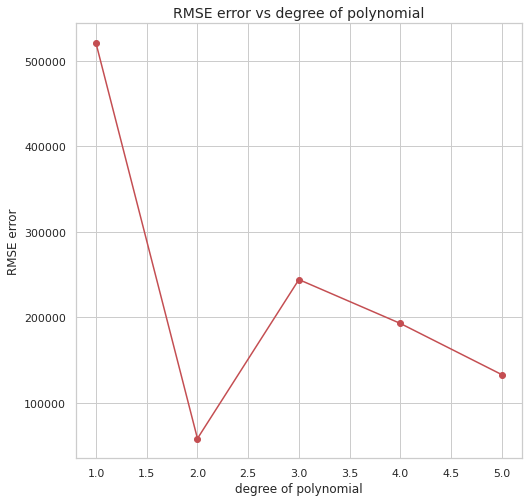

In [0]:
fig,axes = plt.subplots(1,1,figsize=(8,8))
fig.set()
axes.plot(range(1,6),[rmse1,rmse2,rmse3,rmse4,rmse5],'ro-')
axes.set_xlabel('degree of polynomial')
axes.set_ylabel('RMSE error')
axes.set_title('RMSE error vs degree of polynomial',fontdict={'fontsize':14})
fig.show()

### Lasso Regression

Still, we choose the model which yields the lowest RMSE error.

In [0]:

#model1
#Set up first degree polynomial feature, transform data to 2D data
poly_L_1 = PolynomialFeatures(1,interaction_only=False,include_bias=True)
x_train_US_transformed_1 = poly_L_1.fit_transform(x_train_US)
x_test_US_transformed_1 = poly_L_1.fit_transform(x_test_US)
# Initialize parameters that needs to be explored for optimization of the model
alpha = [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,2,5,10]
normalize=[True,False]
tol = [1e-12,1e-11,1e-10,1e-9]

warm_start=[True,False]
# Set up grid
lasso_grid = {'alpha': alpha,'normalize':normalize, 'tol':tol,'warm_start':warm_start}
#Set up bayesian regressor
lasso_regressor = Lasso()
# Use GridSearchCV to explore the best set of parameters
lasso_search = GridSearchCV(estimator = lasso_regressor, param_grid = lasso_grid,scoring='neg_root_mean_squared_error',
                               verbose=1,n_jobs=-1)
lasso_search.fit(x_train_US_transformed_1, y_train_US)
#print out the parameters of the best estimator
print('\n')
print('The parameter set for the best estimator:',lasso_search.best_params_)
print('\n')
# Set up the best estimator
lasso_confirmed_1 = lasso_search.best_estimator_


#model2
#Set up second degree polynomial feature, transform data to 3D data
poly_L_2 = PolynomialFeatures(2,interaction_only=False,include_bias=True)
x_train_US_transformed_2 = poly_L_2.fit_transform(x_train_US)
x_test_US_transformed_2 = poly_L_2.fit_transform(x_test_US)

# Initialize parameters that needs to be explored for optimization of the model
alpha = [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,2,5,10]
normalize=[True,False]
tol = [1e-12,1e-11,1e-10,1e-9,1e-8,1e-7,1e-6,1e-5]
warm_start=[True,False]

# Set up grid
lasso_grid = {'alpha': alpha,'normalize':normalize, 'tol':tol,'warm_start':warm_start}

#Set up bayesian regressor
lasso_regressor = Lasso()
# Use GridSearchCV to explore the best set of parameters
lasso_search = GridSearchCV(estimator = lasso_regressor, param_grid = lasso_grid,scoring='neg_root_mean_squared_error',
                               verbose=1,n_jobs=-1)
lasso_search.fit(x_train_US_transformed_2, y_train_US)
#print out the parameters of the best estimator
print('\n')
print('The parameter set for the best estimator:',lasso_search.best_params_)
print('\n')
# Set up the best estimator
lasso_confirmed_2 = lasso_search.best_estimator_

#model3
#Set up third degree polynomial feature, transform data to 4D data
poly_L_3 = PolynomialFeatures(3,interaction_only=False,include_bias=True)
x_train_US_transformed_3 = poly_L_3.fit_transform(x_train_US)
x_test_US_transformed_3 = poly_L_3.fit_transform(x_test_US)

# Initialize parameters that needs to be explored for optimization of the model
alpha = [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,2,5,10]
normalize=[True,False]
tol = [1e-12,1e-11,1e-10,1e-9,1e-8,1e-7,1e-6,1e-5]
warm_start=[True,False]

# Set up grid
lasso_grid = {'alpha': alpha,'normalize':normalize, 'tol':tol,'warm_start':warm_start}

#Set up bayesian regressor
lasso_regressor = Lasso()
# Use GridSearchCV to explore the best set of parameters
lasso_search = GridSearchCV(estimator = lasso_regressor, param_grid = lasso_grid,scoring='neg_root_mean_squared_error',
                               verbose=1,n_jobs=-1)
lasso_search.fit(x_train_US_transformed_3, y_train_US)
#print out the parameters of the best estimator
print('\n')
print('The parameter set for the best estimator:',lasso_search.best_params_)
print('\n')
# Set up the best estimator
lasso_confirmed_3 = lasso_search.best_estimator_


#model4
#Set up fourth degree polynomial feature, transform data to 5D data
poly_L_4 = PolynomialFeatures(4,interaction_only=False,include_bias=True)
x_train_US_transformed_4 = poly_L_4.fit_transform(x_train_US)
x_test_US_transformed_4 = poly_L_4.fit_transform(x_test_US)

# Initialize parameters that needs to be explored for optimization of the model
alpha = [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,2,5,10]
normalize=[True,False]
tol = [1e-12,1e-11,1e-10,1e-9,1e-8,1e-7,1e-6,1e-5]
warm_start=[True,False]

# Set up grid
lasso_grid = {'alpha': alpha,'normalize':normalize, 'tol':tol,'warm_start':warm_start}

#Set up bayesian regressor
lasso_regressor = Lasso()
# Use GridSearchCV to explore the best set of parameters
lasso_search = GridSearchCV(estimator = lasso_regressor, param_grid = lasso_grid,scoring='neg_root_mean_squared_error',
                               verbose=1,n_jobs=-1)
lasso_search.fit(x_train_US_transformed_4, y_train_US)
#print out the parameters of the best estimator
print('\n')
print('The parameter set for the best estimator:',lasso_search.best_params_)
print('\n')
# Set up the best estimator
lasso_confirmed_4 = lasso_search.best_estimator_


#model5
#Set up fifth degree polynomial feature, transform data to 6D data
poly_L_5 = PolynomialFeatures(5,interaction_only=False,include_bias=True)
x_train_US_transformed_5 = poly_L_5.fit_transform(x_train_US)
x_test_US_transformed_5 = poly_L_5.fit_transform(x_test_US)

# Initialize parameters that needs to be explored for optimization of the model
alpha = [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,2,5,10]
normalize=[True,False]
tol = [1e-12,1e-11,1e-10,1e-9,1e-8,1e-7,1e-6,1e-5]
warm_start=[True,False]

# Set up grid
lasso_grid = {'alpha': alpha,'normalize':normalize, 'tol':tol,'warm_start':warm_start}

#Set up bayesian regressor
lasso_regressor = Lasso()
# Use GridSearchCV to explore the best set of parameters
lasso_search = GridSearchCV(estimator = lasso_regressor, param_grid = lasso_grid,scoring='neg_root_mean_squared_error',
                               verbose=1,n_jobs=-1)
lasso_search.fit(x_train_US_transformed_5, y_train_US)
#print out the parameters of the best estimator
print('\n')
print('The parameter set for the best estimator:',lasso_search.best_params_)
print('\n')
# Set up the best estimator
lasso_confirmed_5 = lasso_search.best_estimator_


#model6
#Set up sixth degree polynomial feature, transform data to 7D data
poly_L_6 = PolynomialFeatures(6,interaction_only=False,include_bias=True)
x_train_US_transformed_6 = poly_L_6.fit_transform(x_train_US)
x_test_US_transformed_6 = poly_L_6.fit_transform(x_test_US)

# Initialize parameters that needs to be explored for optimization of the model
alpha = [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,2,5,10]
normalize=[True,False]
tol = [1e-12,1e-11,1e-10,1e-9,1e-8,1e-7,1e-6,1e-5]
warm_start=[True,False]

# Set up grid
lasso_grid = {'alpha': alpha,'normalize':normalize, 'tol':tol,'warm_start':warm_start}

#Set up bayesian regressor
lasso_regressor = Lasso()
# Use GridSearchCV to explore the best set of parameters
lasso_search = GridSearchCV(estimator = lasso_regressor, param_grid = lasso_grid,scoring='neg_root_mean_squared_error',
                               verbose=1,n_jobs=-1)
lasso_search.fit(x_train_US_transformed_6, y_train_US)
#print out the parameters of the best estimator
print('\n')
print('The parameter set for the best estimator:',lasso_search.best_params_)
print('\n')
# Set up the best estimator
lasso_confirmed_6 = lasso_search.best_estimator_


Fitting 5 folds for each of 160 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.




The parameter set for the best estimator: {'alpha': 10, 'normalize': True, 'tol': 1e-12, 'warm_start': True}


Fitting 5 folds for each of 320 candidates, totalling 1600 fits


[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1600 out of 1600 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.




The parameter set for the best estimator: {'alpha': 10, 'normalize': True, 'tol': 1e-05, 'warm_start': True}


Fitting 5 folds for each of 320 candidates, totalling 1600 fits


[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 1600 out of 1600 | elapsed:    1.4s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31733486434.668823, tolerance: 6.4852298869758735
  positive)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.




The parameter set for the best estimator: {'alpha': 10, 'normalize': False, 'tol': 1e-12, 'warm_start': True}


Fitting 5 folds for each of 320 candidates, totalling 1600 fits


[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1600 out of 1600 | elapsed:    1.3s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 722758652.2289581, tolerance: 6.4852298869758735
  positive)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.




The parameter set for the best estimator: {'alpha': 10, 'normalize': True, 'tol': 1e-12, 'warm_start': True}


Fitting 5 folds for each of 320 candidates, totalling 1600 fits


[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1600 out of 1600 | elapsed:    1.3s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11016088533.301254, tolerance: 6.4852298869758735
  positive)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.




The parameter set for the best estimator: {'alpha': 10, 'normalize': True, 'tol': 1e-12, 'warm_start': True}


Fitting 5 folds for each of 320 candidates, totalling 1600 fits


[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.4s




The parameter set for the best estimator: {'alpha': 10, 'normalize': True, 'tol': 1e-12, 'warm_start': True}




[Parallel(n_jobs=-1)]: Done 1600 out of 1600 | elapsed:    1.3s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10307555290.235458, tolerance: 6.4852298869758735
  positive)


Respectively, RMSE errors from first degree to six degree are:  
 520825.58491449826 
 60254.77529029988 
 225480.98131434928 
 273164.0918860698 
 260418.48303775434 
 231407.4627589214


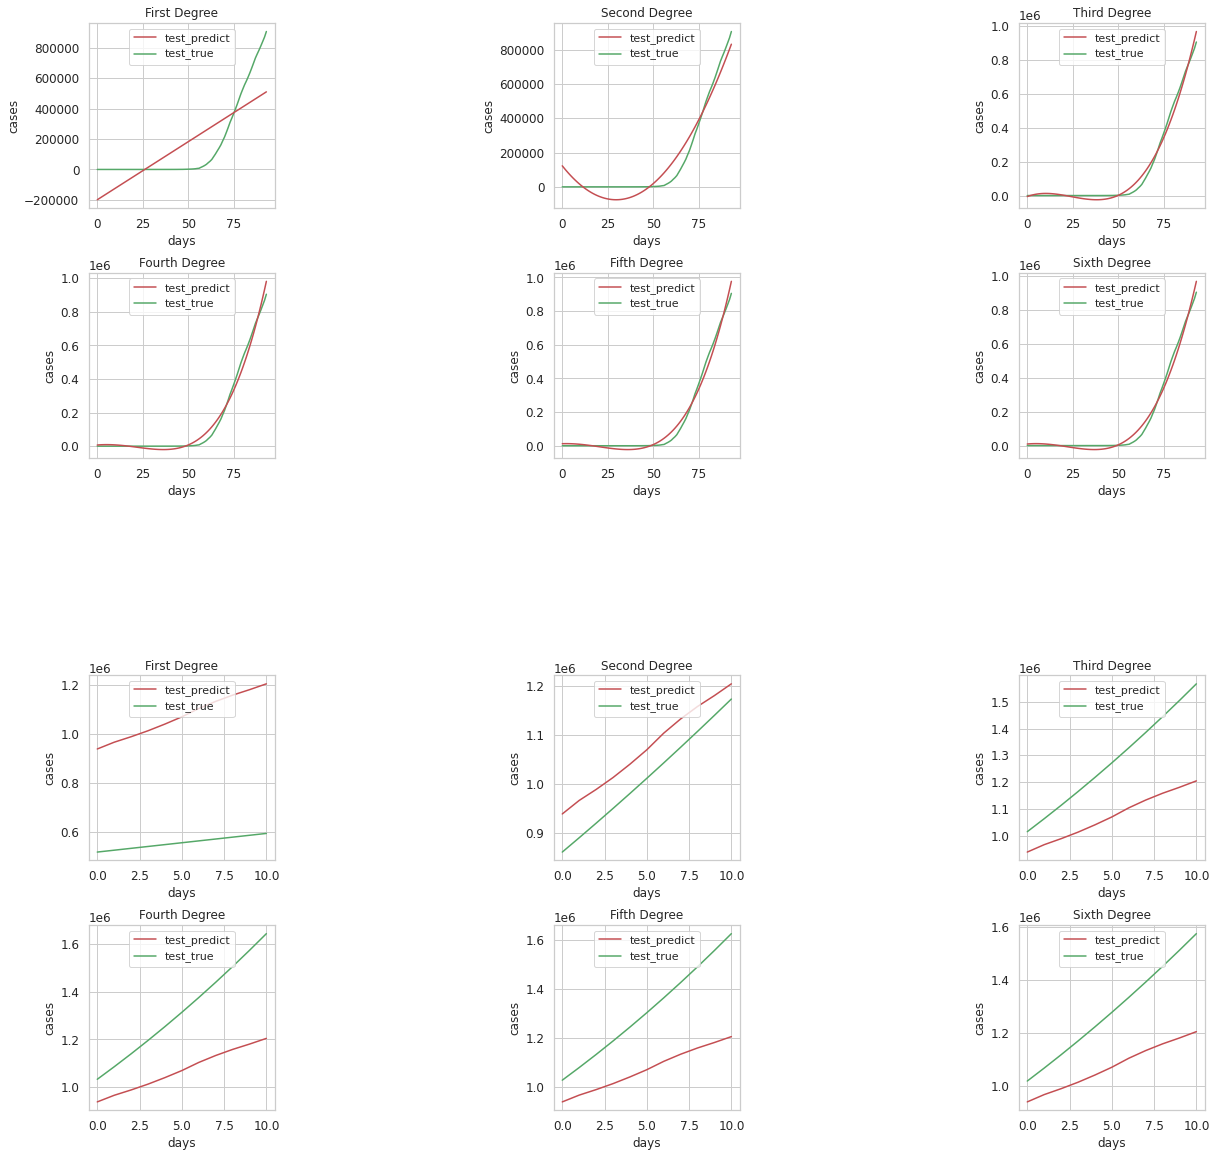

In [0]:
fig = plt.figure(figsize=(20, 20))
outer = gridspec.GridSpec(2, 1, wspace=0.2, hspace=0.5)

#Plot the train data
inner = gridspec.GridSpecFromSubplotSpec(2, 3, subplot_spec=outer[0], wspace=1.5, hspace=0.35)
ax = plt.Subplot(fig,inner[0])
ax.plot(y_train_US,'g-',label='train_true')
ax.plot(lasso_confirmed_1.predict(x_train_US_transformed_1),'r-',label='train_predict')
ax.legend(handles, labels, loc='upper center')
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('First Degree')
fig.add_subplot(ax)


ax = plt.Subplot(fig,inner[1])
ax.plot(y_train_US,'g-',label='train_true')
ax.plot(lasso_confirmed_2.predict(x_train_US_transformed_2),'r-',label='train_predict')
ax.legend(handles, labels, loc='upper center')
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Second Degree')
fig.add_subplot(ax)

ax = plt.Subplot(fig,inner[2])
ax.plot(y_train_US,'g-',label='train_true')
ax.plot(lasso_confirmed_3.predict(x_train_US_transformed_3),'r-',label='train_predict')
ax.legend(handles, labels, loc='upper center')
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Third Degree')
fig.add_subplot(ax)

ax = plt.Subplot(fig,inner[3])
ax.plot(y_train_US,'g-',label='train_true')
ax.plot(lasso_confirmed_4.predict(x_train_US_transformed_4),'r-',label='train_predict')
ax.legend(handles, labels, loc='upper center')
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Fourth Degree')
fig.add_subplot(ax)

ax = plt.Subplot(fig,inner[4])
ax.plot(y_train_US,'g-',label='train_true')
ax.plot(lasso_confirmed_5.predict(x_train_US_transformed_5),'r-',label='train_predict')
ax.legend(handles, labels, loc='upper center')
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Fifth Degree')
fig.add_subplot(ax)

ax = plt.Subplot(fig,inner[5])
ax.plot(y_train_US,'g-',label='train_true')
ax.plot(lasso_confirmed_6.predict(x_train_US_transformed_6),'r-',label='train_predict')
ax.legend(handles, labels, loc='upper center')
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Sixth Degree')
fig.add_subplot(ax)

#Plot the prediction
inner = gridspec.GridSpecFromSubplotSpec(2, 3, subplot_spec=outer[1], wspace=1.5, hspace=0.35)

# Use the best estimator to do the prediction
y_pred_US_1 = lasso_confirmed_1.predict(x_test_US_transformed_1)
L_rmse1 = mean_squared_error(y_test_US, y_pred_US_1,squared=False)
ax = plt.Subplot(fig,inner[0])
ax.plot(y_test_US,'r-',label='test_predict')
ax.plot(y_pred_US_1,'g-',label='test_true')
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('First Degree')
ax.legend(handles, labels, loc='upper center')
fig.add_subplot(ax)

# Use the best estimator to do the prediction
y_pred_US_2 = lasso_confirmed_2.predict(x_test_US_transformed_2)
L_rmse2 = mean_squared_error(y_test_US, y_pred_US_2,squared=False)
ax = plt.Subplot(fig,inner[1])
ax.plot(y_test_US,'r-',label='test_predict')
ax.plot(y_pred_US_2,'g-',label='test_true')
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Second Degree')
ax.legend(handles, labels, loc='upper center')
fig.add_subplot(ax)


# Use the best estimator to do the prediction
y_pred_US_3 = lasso_confirmed_3.predict(x_test_US_transformed_3)
L_rmse3 = mean_squared_error(y_test_US, y_pred_US_3,squared=False)
ax = plt.Subplot(fig,inner[2])
ax.plot(y_test_US,'r-',label='test_predict')
ax.plot(y_pred_US_3,'g-',label='test_true')
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Third Degree')
ax.legend(handles, labels, loc='upper center')
fig.add_subplot(ax)


# Use the best estimator to do the prediction
y_pred_US_4 = lasso_confirmed_4.predict(x_test_US_transformed_4)
L_rmse4 = mean_squared_error(y_test_US, y_pred_US_4,squared=False)
ax = plt.Subplot(fig,inner[3])
ax.plot(y_test_US,'r-',label='test_predict')
ax.plot(y_pred_US_4,'g-',label='test_true')
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Fourth Degree')
ax.legend(handles, labels, loc='upper center')
fig.add_subplot(ax)

# Use the best estimator to do the prediction
y_pred_US_5 = lasso_confirmed_5.predict(x_test_US_transformed_5)
L_rmse5 = mean_squared_error(y_test_US, y_pred_US_5,squared=False)
ax = plt.Subplot(fig,inner[4])
ax.plot(y_test_US,'r-',label='test_predict')
ax.plot(y_pred_US_5,'g-',label='test_true')
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Fifth Degree')
ax.legend(handles, labels, loc='upper center')
fig.add_subplot(ax)

# Use the best estimator to do the prediction
y_pred_US_6 = lasso_confirmed_6.predict(x_test_US_transformed_6)
L_rmse6 = mean_squared_error(y_test_US, y_pred_US_6,squared=False)
ax = plt.Subplot(fig,inner[5])
ax.plot(y_test_US,'r-',label='test_predict')
ax.plot(y_pred_US_6,'g-',label='test_true')
ax.legend(handles, labels, loc='upper center')
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Sixth Degree')
fig.add_subplot(ax)
fig.show()
print('Respectively, RMSE errors from first degree to six degree are: ','\n',L_rmse1,'\n',L_rmse2,'\n',L_rmse3,'\n',L_rmse4,'\n',L_rmse5,'\n',L_rmse6)

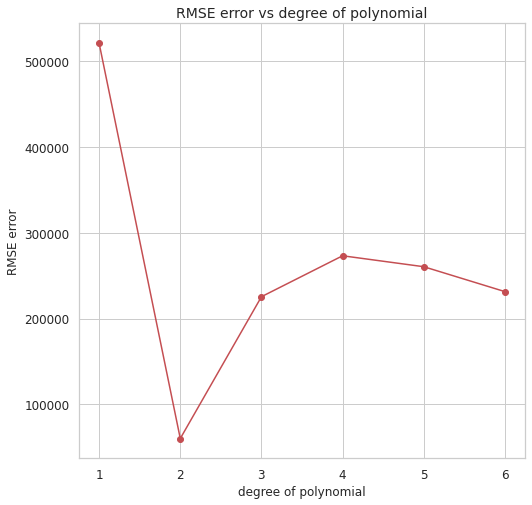

In [0]:
fig,axes = plt.subplots(1,1,figsize=(8,8))
fig.set()
axes.plot(range(1,7),[L_rmse1,L_rmse2,L_rmse3,L_rmse4,L_rmse5,L_rmse6],'ro-')
axes.set_xlabel('degree of polynomial')
axes.set_ylabel('RMSE error')
axes.set_title('RMSE error vs degree of polynomial',fontdict={'fontsize':14})
fig.show()

### Ridge Regression

Still, we choose the model which yields the lowest RMSE error.

In [0]:
#model1
#Set up second degree polynomial feature, transform data to 3D data
poly_R_1 = PolynomialFeatures(1,interaction_only=False,include_bias=True)
x_train_US_transformed_1 = poly_R_1.fit_transform(x_train_US)
x_test_US_transformed_1 = poly_R_1.fit_transform(x_test_US)

# Initialize parameters that needs to be explored for optimization of the model
alpha = [1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,2]
normalize=[True,False]
tol = [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1]

# Set up grid
ridge_grid = {'alpha': alpha,'normalize':normalize, 'tol':tol}

#Set up bayesian regressor
ridge_regressor = Ridge()
# Use GridSearchCV to explore the best set of parameters
ridge_search = GridSearchCV(estimator = ridge_regressor, param_grid = ridge_grid,scoring='neg_root_mean_squared_error',
                               verbose=1,n_jobs=-1)
ridge_search.fit(x_train_US_transformed_1, y_train_US)
#print out the parameters of the best estimator
print('The parameter set for the best estimator:',ridge_search.best_params_)
# Set up the best estimator
ridge_confirmed_1 = ridge_search.best_estimator_



#model2
#Set up second degree polynomial feature, transform data to 3D data
poly_R_2 = PolynomialFeatures(2,interaction_only=False,include_bias=True)
x_train_US_transformed_2 = poly_R_2.fit_transform(x_train_US)
x_test_US_transformed_2 = poly_R_2.fit_transform(x_test_US)

# Initialize parameters that needs to be explored for optimization of the model
alpha = [1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,2]
normalize=[True,False]
tol = [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1]

# Set up grid
ridge_grid = {'alpha': alpha,'normalize':normalize, 'tol':tol}

#Set up bayesian regressor
ridge_regressor = Ridge()
# Use GridSearchCV to explore the best set of parameters
ridge_search = GridSearchCV(estimator = ridge_regressor, param_grid = ridge_grid,scoring='neg_root_mean_squared_error',
                               verbose=1,n_jobs=-1)
ridge_search.fit(x_train_US_transformed_2, y_train_US)
#print out the parameters of the best estimator
print('The parameter set for the best estimator:',ridge_search.best_params_)
# Set up the best estimator
ridge_confirmed_2 = ridge_search.best_estimator_


#model3
#Set up second degree polynomial feature, transform data to 3D data
poly_R_3 = PolynomialFeatures(3,interaction_only=False,include_bias=True)
x_train_US_transformed_3 = poly_R_3.fit_transform(x_train_US)
x_test_US_transformed_3 = poly_R_3.fit_transform(x_test_US)

# Initialize parameters that needs to be explored for optimization of the model
alpha = [1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,2]
normalize=[True,False]
tol = [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1]

# Set up grid
ridge_grid = {'alpha': alpha,'normalize':normalize, 'tol':tol}
#Set up bayesian regressor
ridge_regressor = Ridge()
# Use GridSearchCV to explore the best set of parameters
ridge_search = GridSearchCV(estimator = ridge_regressor, param_grid = ridge_grid,scoring='neg_root_mean_squared_error',
                               verbose=1,n_jobs=-1)
ridge_search.fit(x_train_US_transformed_3, y_train_US)
#print out the parameters of the best estimator
print('The parameter set for the best estimator:',ridge_search.best_params_)
# Set up the best estimator
ridge_confirmed_3 = ridge_search.best_estimator_



#model4
#Set up second degree polynomial feature, transform data to 3D data
poly_R_4 = PolynomialFeatures(4,interaction_only=False,include_bias=True)
x_train_US_transformed_4 = poly_R_4.fit_transform(x_train_US)
x_test_US_transformed_4 = poly_R_4.fit_transform(x_test_US)

# Initialize parameters that needs to be explored for optimization of the model
alpha = [1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,2]
normalize=[True,False]
tol = [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1]

# Set up grid
ridge_grid = {'alpha': alpha,'normalize':normalize, 'tol':tol}

#Set up bayesian regressor
ridge_regressor = Ridge()
# Use GridSearchCV to explore the best set of parameters
ridge_search = GridSearchCV(estimator = ridge_regressor, param_grid = ridge_grid,scoring='neg_root_mean_squared_error',
                               verbose=1,n_jobs=-1)
ridge_search.fit(x_train_US_transformed_4, y_train_US)
#print out the parameters of the best estimator
print('The parameter set for the best estimator:',ridge_search.best_params_)
# Set up the best estimator
ridge_confirmed_4 = ridge_search.best_estimator_



#model5
#Set up second degree polynomial feature, transform data to 3D data
poly_R_5 = PolynomialFeatures(5,interaction_only=False,include_bias=True)
x_train_US_transformed_5 = poly_R_5.fit_transform(x_train_US)
x_test_US_transformed_5 = poly_R_5.fit_transform(x_test_US)

# Initialize parameters that needs to be explored for optimization of the model
alpha = [1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,2]
normalize=[True,False]
tol = [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1]

# Set up grid
ridge_grid = {'alpha': alpha,'normalize':normalize, 'tol':tol}

#Set up bayesian regressor
ridge_regressor = Ridge()
# Use GridSearchCV to explore the best set of parameters
ridge_search = GridSearchCV(estimator = ridge_regressor, param_grid = ridge_grid,scoring='neg_root_mean_squared_error',
                               verbose=1,n_jobs=-1)
ridge_search.fit(x_train_US_transformed_5, y_train_US)
#print out the parameters of the best estimator
print('The parameter set for the best estimator:',ridge_search.best_params_)
# Set up the best estimator
ridge_confirmed_5 = ridge_search.best_estimator_



#model6
#Set up second degree polynomial feature, transform data to 3D data
poly_R_6 = PolynomialFeatures(6,interaction_only=False,include_bias=True)
x_train_US_transformed_6 = poly_R_6.fit_transform(x_train_US)
x_test_US_transformed_6 = poly_R_6.fit_transform(x_test_US)

# Initialize parameters that needs to be explored for optimization of the model
alpha = [1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,2]
normalize=[True,False]
tol = [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1]

# Set up grid
ridge_grid = {'alpha': alpha,'normalize':normalize, 'tol':tol}

#Set up bayesian regressor
ridge_regressor = Ridge()
# Use GridSearchCV to explore the best set of parameters
ridge_search = GridSearchCV(estimator = ridge_regressor, param_grid = ridge_grid,scoring='neg_root_mean_squared_error',
                               verbose=1,n_jobs=-1)
ridge_search.fit(x_train_US_transformed_6, y_train_US)
#print out the parameters of the best estimator
print('The parameter set for the best estimator:',ridge_search.best_params_)
# Set up the best estimator
ridge_confirmed_6 = ridge_search.best_estimator_


Fitting 5 folds for each of 126 candidates, totalling 630 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 630 out of 630 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


The parameter set for the best estimator: {'alpha': 2, 'normalize': True, 'tol': 1e-06}
Fitting 5 folds for each of 126 candidates, totalling 630 fits


[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 630 out of 630 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


The parameter set for the best estimator: {'alpha': 0.01, 'normalize': True, 'tol': 1e-06}
Fitting 5 folds for each of 126 candidates, totalling 630 fits


[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 630 out of 630 | elapsed:    0.4s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.96234e-20): result may not be accurate.
  overwrite_a=True).T
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


The parameter set for the best estimator: {'alpha': 1e-07, 'normalize': False, 'tol': 1e-06}
Fitting 5 folds for each of 126 candidates, totalling 630 fits


[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 630 out of 630 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


The parameter set for the best estimator: {'alpha': 0.01, 'normalize': True, 'tol': 1e-06}
Fitting 5 folds for each of 126 candidates, totalling 630 fits


[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 630 out of 630 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


The parameter set for the best estimator: {'alpha': 0.01, 'normalize': True, 'tol': 1e-06}
Fitting 5 folds for each of 126 candidates, totalling 630 fits
The parameter set for the best estimator: {'alpha': 0.1, 'normalize': True, 'tol': 1e-06}


[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 630 out of 630 | elapsed:    0.4s finished


Respectively, RMSE errors from first degree to six degree are:  
 787433.2320439656 
 140048.68614598853 
 244152.66420479494 
 192631.46047704387 
 279061.23773195763 
 272624.03775499563


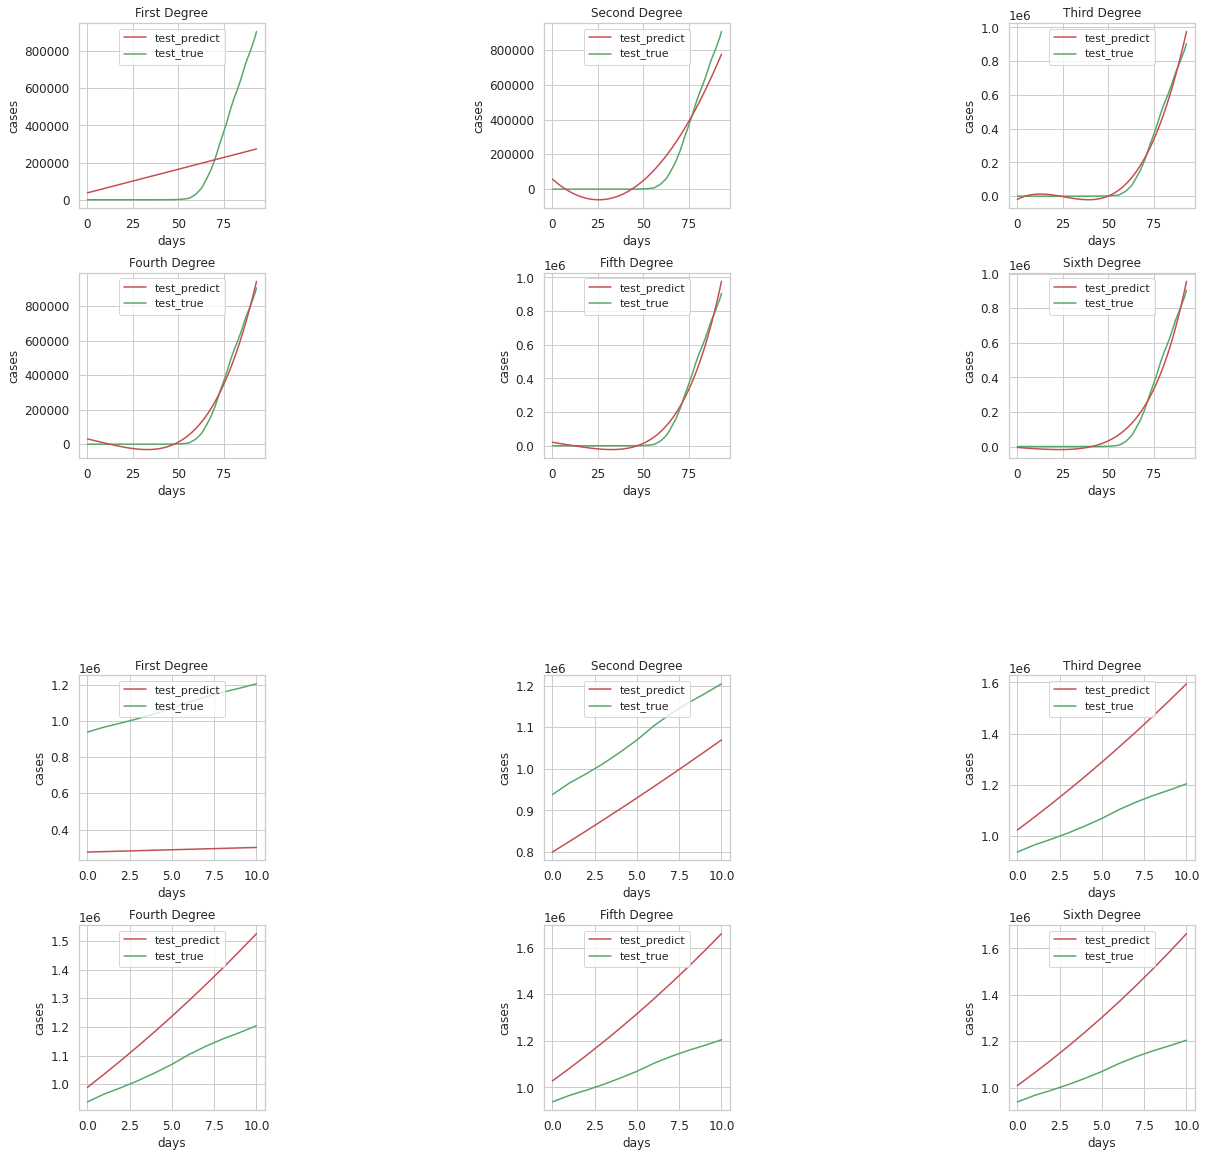

In [0]:
fig = plt.figure(figsize=(20, 20))
outer = gridspec.GridSpec(2, 1, wspace=0.2, hspace=0.5)

#Plot the train data
inner = gridspec.GridSpecFromSubplotSpec(2, 3, subplot_spec=outer[0], wspace=1.5, hspace=0.35)
ax = plt.Subplot(fig,inner[0])
ax.plot(y_train_US,'g-',label='train_true')
ax.plot(ridge_confirmed_1.predict(x_train_US_transformed_1),'r-',label='train_predict')
ax.legend(handles, labels, loc='upper center')
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('First Degree')
fig.add_subplot(ax)


ax = plt.Subplot(fig,inner[1])
ax.plot(y_train_US,'g-',label='train_true')
ax.plot(ridge_confirmed_2.predict(x_train_US_transformed_2),'r-',label='train_predict')
ax.legend(handles, labels, loc='upper center')
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Second Degree')
fig.add_subplot(ax)

ax = plt.Subplot(fig,inner[2])
ax.plot(y_train_US,'g-',label='train_true')
ax.plot(ridge_confirmed_3.predict(x_train_US_transformed_3),'r-',label='train_predict')
ax.legend(handles, labels, loc='upper center')
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Third Degree')
fig.add_subplot(ax)

ax = plt.Subplot(fig,inner[3])
ax.plot(y_train_US,'g-',label='train_true')
ax.plot(ridge_confirmed_4.predict(x_train_US_transformed_4),'r-',label='train_predict')
ax.legend(handles, labels, loc='upper center')
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Fourth Degree')
fig.add_subplot(ax)

ax = plt.Subplot(fig,inner[4])
ax.plot(y_train_US,'g-',label='train_true')
ax.plot(ridge_confirmed_5.predict(x_train_US_transformed_5),'r-',label='train_predict')
ax.legend(handles, labels, loc='upper center')
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Fifth Degree')
fig.add_subplot(ax)

ax = plt.Subplot(fig,inner[5])
ax.plot(y_train_US,'g-',label='train_true')
ax.plot(ridge_confirmed_6.predict(x_train_US_transformed_6),'r-',label='train_predict')
ax.legend(handles, labels, loc='upper center')
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Sixth Degree')
fig.add_subplot(ax)

#Plot the prediction
inner = gridspec.GridSpecFromSubplotSpec(2, 3, subplot_spec=outer[1], wspace=1.5, hspace=0.35)

# Use the best estimator to do the prediction
y_pred_US_1 = ridge_confirmed_1.predict(x_test_US_transformed_1)
R_rmse1 = mean_squared_error(y_test_US, y_pred_US_1,squared=False)
ax = plt.Subplot(fig,inner[0])
ax.plot(y_test_US,'g-',label='test_true')
ax.plot(y_pred_US_1,'r-',label='test_predict')
ax.legend(handles, labels, loc='upper center')
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('First Degree')
fig.add_subplot(ax)

# Use the best estimator to do the prediction
y_pred_US_2 = ridge_confirmed_2.predict(x_test_US_transformed_2)
R_rmse2 = mean_squared_error(y_test_US, y_pred_US_2,squared=False)
ax = plt.Subplot(fig,inner[1])
ax.plot(y_test_US,'g-',label='test_true')
ax.plot(y_pred_US_2,'r-',label='test_predict')
ax.legend(handles, labels, loc='upper center')
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Second Degree')
fig.add_subplot(ax)


# Use the best estimator to do the prediction
y_pred_US_3 = ridge_confirmed_3.predict(x_test_US_transformed_3)
R_rmse3 = mean_squared_error(y_test_US, y_pred_US_3,squared=False)
ax = plt.Subplot(fig,inner[2])
ax.plot(y_test_US,'g-',label='test_true')
ax.plot(y_pred_US_3,'r-',label='test_predict')
ax.legend(handles, labels, loc='upper center')
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Third Degree')
fig.add_subplot(ax)


# Use the best estimator to do the prediction
y_pred_US_4 = ridge_confirmed_4.predict(x_test_US_transformed_4)
R_rmse4 = mean_squared_error(y_test_US, y_pred_US_4,squared=False)
ax = plt.Subplot(fig,inner[3])
ax.plot(y_test_US,'g-',label='test_true')
ax.plot(y_pred_US_4,'r-',label='test_predict')
ax.legend(handles, labels, loc='upper center')
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Fourth Degree')
fig.add_subplot(ax)

# Use the best estimator to do the prediction
y_pred_US_5 = ridge_confirmed_5.predict(x_test_US_transformed_5)
R_rmse5 = mean_squared_error(y_test_US, y_pred_US_5,squared=False)
ax = plt.Subplot(fig,inner[4])
ax.plot(y_test_US,'g-',label='test_true')
ax.plot(y_pred_US_5,'r-',label='test_predict')
ax.legend(handles, labels, loc='upper center')
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Fifth Degree')
fig.add_subplot(ax)

# Use the best estimator to do the prediction
y_pred_US_6 = ridge_confirmed_6.predict(x_test_US_transformed_6)
R_rmse6 = mean_squared_error(y_test_US, y_pred_US_6,squared=False)
ax = plt.Subplot(fig,inner[5])
ax.plot(y_test_US,'g-',label='test_true')
ax.plot(y_pred_US_6,'r-',label='test_predict')
ax.legend(handles, labels, loc='upper center')
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Sixth Degree')
fig.add_subplot(ax)
fig.show()
print('Respectively, RMSE errors from first degree to six degree are: ','\n',R_rmse1,'\n',R_rmse2,'\n',R_rmse3,'\n',R_rmse4,'\n',R_rmse5,'\n',R_rmse6)

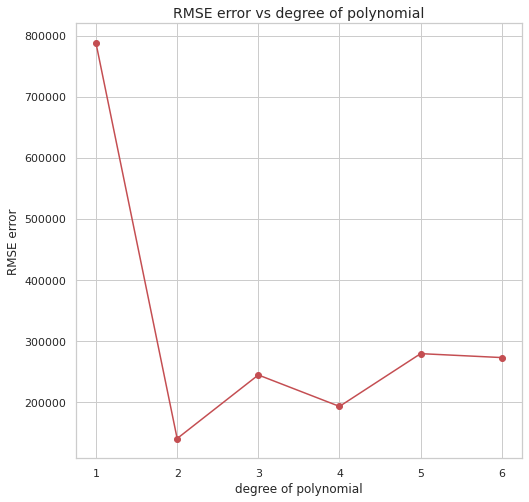

In [0]:
fig,axes = plt.subplots(1,1,figsize=(8,8))
fig.set()
axes.plot(range(1,7),[R_rmse1,R_rmse2,R_rmse3,R_rmse4,R_rmse5,R_rmse6],'ro-')
axes.set_xlabel('degree of polynomial')
axes.set_ylabel('RMSE error')
axes.set_title('RMSE error vs degree of polynomial',fontdict={'fontsize':14})
fig.show()

### ElasticNet Regression (Combine Lasso and Ridge)

Still, we choose the model which yields the lowest RMSE error.

In [0]:
#model1
#Set up first degree polynomial feature, transform data to 2D data
poly_E_1 = PolynomialFeatures(1,interaction_only=False,include_bias=True)
x_train_US_transformed_1 = poly_E_1.fit_transform(x_train_US)
x_test_US_transformed_1 = poly_E_1.fit_transform(x_test_US)

# Initialize parameters that needs to be explored for optimization of the model
alpha = [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,2,5]
normalize=[True,False]
warm_start = [True,False]
tol = [1e-4,1e-3,1e-2,1e-1,1]
l1_ratio = [0.001,0.01,0.1,0.3,0.5,0.8,1]

# Set up grid
elastic_grid = {'l1_ratio':l1_ratio ,'alpha': alpha,'normalize':normalize, 'tol':tol,'warm_start':warm_start}

#Set up bayesian regressor
elastic_regressor = ElasticNet()
# Use GridSearchCV to explore the best set of parameters
elastic_search = GridSearchCV(estimator = elastic_regressor, param_grid = elastic_grid,scoring='neg_root_mean_squared_error',
                               verbose=1,n_jobs=-1)
elastic_search.fit(x_train_US_transformed_1, y_train_US)
#print out the parameters of the best estimator
print('The parameter set for the best estimator:',elastic_search.best_params_)
# Set up the best estimator
elastic_confirmed_1 = elastic_search.best_estimator_



#model2
#Set up first degree polynomial feature, transform data to 2D data
poly_E_2 = PolynomialFeatures(2,interaction_only=False,include_bias=True)
x_train_US_transformed_2 = poly_E_2.fit_transform(x_train_US)
x_test_US_transformed_2 = poly_E_2.fit_transform(x_test_US)

# Initialize parameters that needs to be explored for optimization of the model
alpha = [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,2,5]
normalize=[True,False]
warm_start = [True,False]
tol = [1e-4,1e-3,1e-2,1e-1,1]
l1_ratio = [0.001,0.01,0.1,0.3,0.5,0.8,1]

# Set up grid
elastic_grid = {'l1_ratio':l1_ratio ,'alpha': alpha,'normalize':normalize, 'tol':tol,'warm_start':warm_start}

#Set up bayesian regressor
elastic_regressor = ElasticNet()
# Use GridSearchCV to explore the best set of parameters
elastic_search = GridSearchCV(estimator = elastic_regressor, param_grid = elastic_grid,scoring='neg_root_mean_squared_error',
                               verbose=1,n_jobs=-1)
elastic_search.fit(x_train_US_transformed_2, y_train_US)
#print out the parameters of the best estimator
print('The parameter set for the best estimator:',elastic_search.best_params_)
# Set up the best estimator
elastic_confirmed_2 = elastic_search.best_estimator_


#model3
#Set up third degree polynomial feature, transform data to 2D data
poly_E_3 = PolynomialFeatures(3,interaction_only=False,include_bias=True)
x_train_US_transformed_3 = poly_E_3.fit_transform(x_train_US)
x_test_US_transformed_3 = poly_E_3.fit_transform(x_test_US)

# Initialize parameters that needs to be explored for optimization of the model
alpha = [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,2,5]
normalize=[True,False]
warm_start = [True,False]
tol = [1e-4,1e-3,1e-2,1e-1,1]
l1_ratio = [0.001,0.01,0.1,0.3,0.5,0.8,1]

# Set up grid
elastic_grid = {'l1_ratio':l1_ratio ,'alpha': alpha,'normalize':normalize, 'tol':tol,'warm_start':warm_start}

#Set up bayesian regressor
elastic_regressor = ElasticNet()
# Use GridSearchCV to explore the best set of parameters
elastic_search = GridSearchCV(estimator = elastic_regressor, param_grid = elastic_grid,scoring='neg_root_mean_squared_error',
                               verbose=1,n_jobs=-1)
elastic_search.fit(x_train_US_transformed_3, y_train_US)
#print out the parameters of the best estimator
print('The parameter set for the best estimator:',elastic_search.best_params_)
# Set up the best estimator
elastic_confirmed_3 = elastic_search.best_estimator_



#model4
#Set up fourth degree polynomial feature, transform data to 5D data
poly_E_4 = PolynomialFeatures(4,interaction_only=False,include_bias=True)
x_train_US_transformed_4 = poly_E_4.fit_transform(x_train_US)
x_test_US_transformed_4 = poly_E_4.fit_transform(x_test_US)

# Initialize parameters that needs to be explored for optimization of the model
alpha = [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,2,5]
normalize=[True,False]
warm_start = [True,False]
tol = [1e-4,1e-3,1e-2,1e-1,1]
l1_ratio = [0.001,0.01,0.1,0.3,0.5,0.8,1]

# Set up grid
elastic_grid = {'l1_ratio':l1_ratio ,'alpha': alpha,'normalize':normalize, 'tol':tol,'warm_start':warm_start}

#Set up bayesian regressor
elastic_regressor = ElasticNet()
# Use GridSearchCV to explore the best set of parameters
elastic_search = GridSearchCV(estimator = elastic_regressor, param_grid = elastic_grid,scoring='neg_root_mean_squared_error',
                               verbose=1,n_jobs=-1)
elastic_search.fit(x_train_US_transformed_4, y_train_US)
#print out the parameters of the best estimator
print('The parameter set for the best estimator:',elastic_search.best_params_)
# Set up the best estimator
elastic_confirmed_4 = elastic_search.best_estimator_



#model5
#Set up first degree polynomial feature, transform data to 2D data
poly_E_5 = PolynomialFeatures(5,interaction_only=False,include_bias=True)
x_train_US_transformed_5 = poly_E_5.fit_transform(x_train_US)
x_test_US_transformed_5 = poly_E_5.fit_transform(x_test_US)

# Initialize parameters that needs to be explored for optimization of the model
alpha = [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,2,5]
normalize=[True,False]
warm_start = [True,False]
tol = [1e-4,1e-3,1e-2,1e-1,1]
l1_ratio = [0.001,0.01,0.1,0.3,0.5,0.8,1]

# Set up grid
elastic_grid = {'l1_ratio':l1_ratio ,'alpha': alpha,'normalize':normalize, 'tol':tol,'warm_start':warm_start}

#Set up bayesian regressor
elastic_regressor = ElasticNet()
# Use GridSearchCV to explore the best set of parameters
elastic_search = GridSearchCV(estimator = elastic_regressor, param_grid = elastic_grid,scoring='neg_root_mean_squared_error',
                               verbose=1,n_jobs=-1)
elastic_search.fit(x_train_US_transformed_5, y_train_US)
#print out the parameters of the best estimator
print('The parameter set for the best estimator:',elastic_search.best_params_)
# Set up the best estimator
elastic_confirmed_5 = elastic_search.best_estimator_



#model6
#Set up first degree polynomial feature, transform data to 2D data
poly_E_6 = PolynomialFeatures(6,interaction_only=False,include_bias=True)
x_train_US_transformed_6 = poly_E_6.fit_transform(x_train_US)
x_test_US_transformed_6 = poly_E_6.fit_transform(x_test_US)

# Initialize parameters that needs to be explored for optimization of the model
alpha = [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,2,5]
normalize=[True,False]
warm_start = [True,False]
tol = [1e-4,1e-3,1e-2,1e-1,1]
l1_ratio = [0.001,0.01,0.1,0.3,0.5,0.8,1]

# Set up grid
elastic_grid = {'l1_ratio':l1_ratio ,'alpha': alpha,'normalize':normalize, 'tol':tol,'warm_start':warm_start}

#Set up bayesian regressor
elastic_regressor = ElasticNet()
# Use GridSearchCV to explore the best set of parameters
elastic_search = GridSearchCV(estimator = elastic_regressor, param_grid = elastic_grid,scoring='neg_root_mean_squared_error',
                               verbose=1,n_jobs=-1)
elastic_search.fit(x_train_US_transformed_6, y_train_US)
#print out the parameters of the best estimator
print('The parameter set for the best estimator:',elastic_search.best_params_)
# Set up the best estimator
elastic_confirmed_6 = elastic_search.best_estimator_

Fitting 5 folds for each of 1260 candidates, totalling 6300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 6300 out of 6300 | elapsed:    2.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


The parameter set for the best estimator: {'alpha': 0.1, 'l1_ratio': 0.8, 'normalize': True, 'tol': 0.0001, 'warm_start': True}
Fitting 5 folds for each of 1260 candidates, totalling 6300 fits


[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 6300 out of 6300 | elapsed:    3.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


The parameter set for the best estimator: {'alpha': 0.001, 'l1_ratio': 0.8, 'normalize': True, 'tol': 0.0001, 'warm_start': True}
Fitting 5 folds for each of 1260 candidates, totalling 6300 fits


[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 6300 out of 6300 | elapsed:    3.6s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34980301163.93314, tolerance: 648522988.6975875
  positive)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


The parameter set for the best estimator: {'alpha': 5, 'l1_ratio': 0.1, 'normalize': False, 'tol': 0.0001, 'warm_start': True}
Fitting 5 folds for each of 1260 candidates, totalling 6300 fits


[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 6300 out of 6300 | elapsed:    3.5s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 59868571141.70763, tolerance: 648522988.6975875
  positive)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


The parameter set for the best estimator: {'alpha': 0.0001, 'l1_ratio': 0.5, 'normalize': True, 'tol': 0.0001, 'warm_start': True}
Fitting 5 folds for each of 1260 candidates, totalling 6300 fits


[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 6300 out of 6300 | elapsed:    3.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


The parameter set for the best estimator: {'alpha': 0.001, 'l1_ratio': 0.5, 'normalize': True, 'tol': 0.01, 'warm_start': True}
Fitting 5 folds for each of 1260 candidates, totalling 6300 fits


[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.4s


The parameter set for the best estimator: {'alpha': 0.01, 'l1_ratio': 0.8, 'normalize': True, 'tol': 0.1, 'warm_start': True}


[Parallel(n_jobs=-1)]: Done 6300 out of 6300 | elapsed:    3.6s finished


Respectively, RMSE errors from first degree to six degree are:  
 781873.3002188875 
 187501.72573149783 
 218622.34849874736 
 222110.0429098737 
 223428.94686781423 
 230170.52025826645


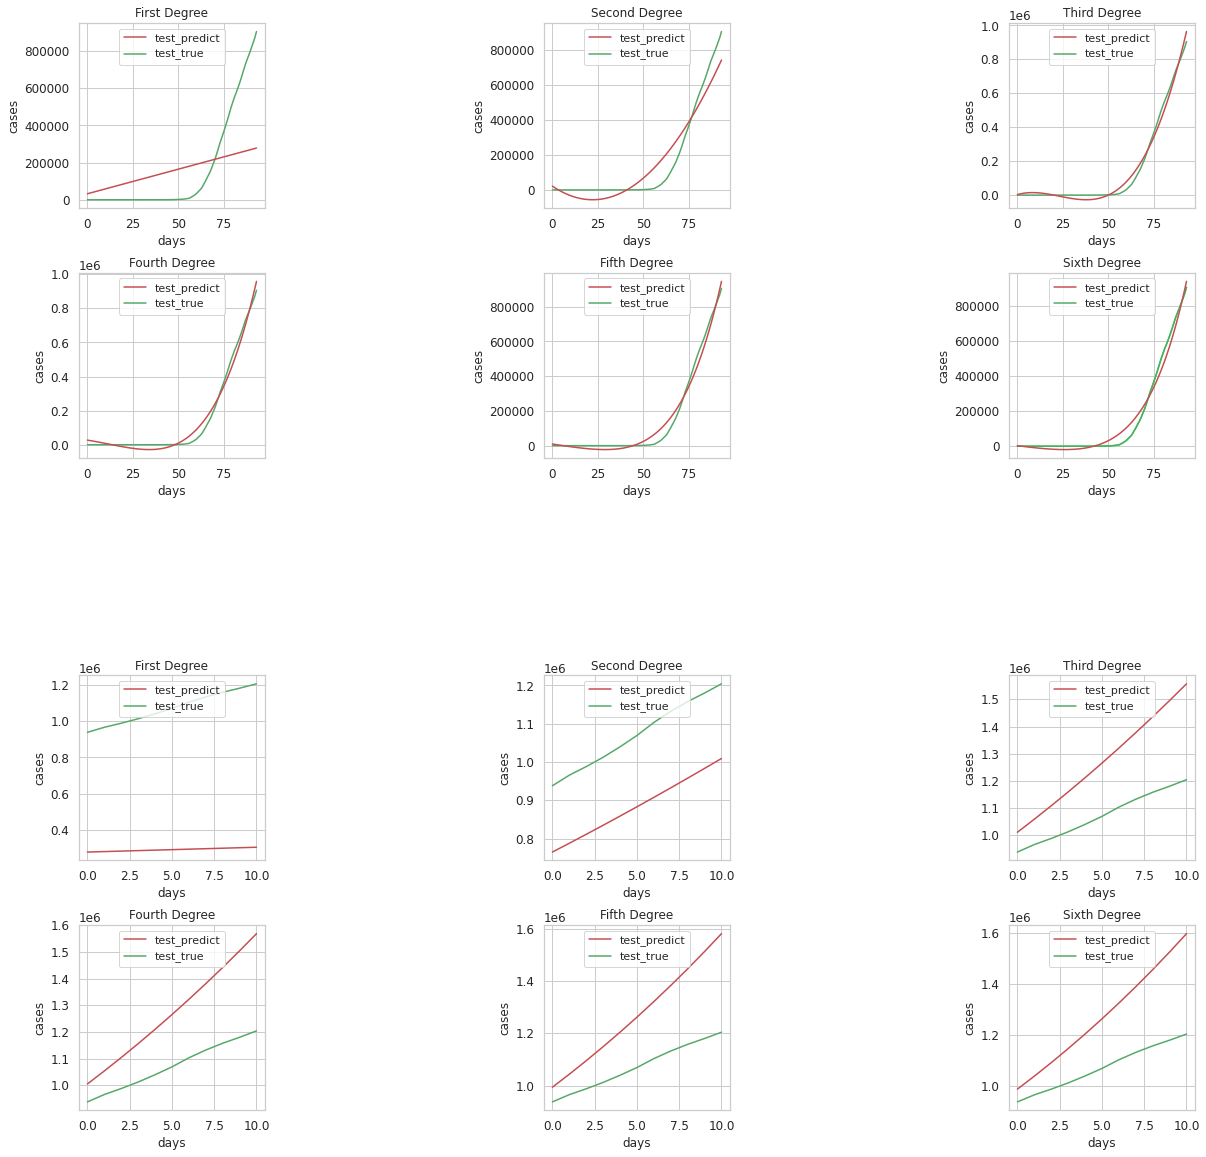

In [0]:
fig = plt.figure(figsize=(20, 20))
outer = gridspec.GridSpec(2, 1, wspace=0.2, hspace=0.5)

#Plot the train data
inner = gridspec.GridSpecFromSubplotSpec(2, 3, subplot_spec=outer[0], wspace=1.5, hspace=0.35)
ax = plt.Subplot(fig,inner[0])
ax.plot(y_train_US,'g-',label='train_true')
ax.plot(elastic_confirmed_1.predict(x_train_US_transformed_1),'r-',label='train_predict')
ax.legend(handles, labels, loc='upper center')
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('First Degree')
fig.add_subplot(ax)


ax = plt.Subplot(fig,inner[1])
ax.plot(y_train_US,'g-',label='train_true')
ax.plot(elastic_confirmed_2.predict(x_train_US_transformed_2),'r-',label='train_predict')
ax.legend(handles, labels, loc='upper center')
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Second Degree')
fig.add_subplot(ax)

ax = plt.Subplot(fig,inner[2])
ax.plot(y_train_US,'g-',label='train_true')
ax.plot(elastic_confirmed_3.predict(x_train_US_transformed_3),'r-',label='train_predict')
ax.legend(handles, labels, loc='upper center')
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Third Degree')
fig.add_subplot(ax)

ax = plt.Subplot(fig,inner[3])
ax.plot(y_train_US,'g-',label='train_true')
ax.plot(elastic_confirmed_4.predict(x_train_US_transformed_4),'r-',label='train_predict')
ax.legend(handles, labels, loc='upper center')
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Fourth Degree')
fig.add_subplot(ax)

ax = plt.Subplot(fig,inner[4])
ax.plot(y_train_US,'g-',label='train_true')
ax.plot(elastic_confirmed_5.predict(x_train_US_transformed_5),'r-',label='train_predict')
ax.legend(handles, labels, loc='upper center')
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Fifth Degree')
fig.add_subplot(ax)

ax = plt.Subplot(fig,inner[5])
ax.plot(y_train_US)
ax.plot(y_train_US,'g-',label='train_true')
ax.plot(elastic_confirmed_6.predict(x_train_US_transformed_6),'r-',label='train_predict')
ax.legend(handles, labels, loc='upper center')
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Sixth Degree')
fig.add_subplot(ax)

#Plot the prediction
inner = gridspec.GridSpecFromSubplotSpec(2, 3, subplot_spec=outer[1], wspace=1.5, hspace=0.35)

# Use the best estimator to do the prediction
y_pred_US_1 = elastic_confirmed_1.predict(x_test_US_transformed_1)
E_rmse1 = mean_squared_error(y_test_US, y_pred_US_1,squared=False)
ax = plt.Subplot(fig,inner[0])
ax.plot(y_test_US,'g-',label='test_true')
ax.plot(y_pred_US_1,'r-',label='test_predict')
ax.legend(handles, labels, loc='upper center')
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('First Degree')
fig.add_subplot(ax)

# Use the best estimator to do the prediction
y_pred_US_2 = elastic_confirmed_2.predict(x_test_US_transformed_2)
E_rmse2 = mean_squared_error(y_test_US, y_pred_US_2,squared=False)
ax = plt.Subplot(fig,inner[1])
ax.plot(y_test_US,'g-',label='test_true')
ax.plot(y_pred_US_2,'r-',label='test_predict')
ax.legend(handles, labels, loc='upper center')
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Second Degree')
fig.add_subplot(ax)


# Use the best estimator to do the prediction
y_pred_US_3 = elastic_confirmed_3.predict(x_test_US_transformed_3)
E_rmse3 = mean_squared_error(y_test_US, y_pred_US_3,squared=False)
ax = plt.Subplot(fig,inner[2])
ax.plot(y_test_US,'g-',label='test_true')
ax.plot(y_pred_US_3,'r-',label='test_predict')
ax.legend(handles, labels, loc='upper center')
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Third Degree')
fig.add_subplot(ax)


# Use the best estimator to do the prediction
y_pred_US_4 = elastic_confirmed_4.predict(x_test_US_transformed_4)
E_rmse4 = mean_squared_error(y_test_US, y_pred_US_4,squared=False)
ax = plt.Subplot(fig,inner[3])
ax.plot(y_test_US,'g-',label='test_true')
ax.plot(y_pred_US_4,'r-',label='test_predict')
ax.legend(handles, labels, loc='upper center')
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Fourth Degree')
fig.add_subplot(ax)

# Use the best estimator to do the prediction
y_pred_US_5 = elastic_confirmed_5.predict(x_test_US_transformed_5)
E_rmse5 = mean_squared_error(y_test_US, y_pred_US_5,squared=False)
ax = plt.Subplot(fig,inner[4])
ax.plot(y_test_US,'g-',label='test_true')
ax.plot(y_pred_US_5,'r-',label='test_predict')
ax.legend(handles, labels, loc='upper center')
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Fifth Degree')
fig.add_subplot(ax)

# Use the best estimator to do the prediction
y_pred_US_6 = elastic_confirmed_6.predict(x_test_US_transformed_6)
E_rmse6 = mean_squared_error(y_test_US, y_pred_US_6,squared=False)
ax = plt.Subplot(fig,inner[5])
ax.plot(y_test_US,'g-',label='test_true')
ax.plot(y_pred_US_6,'r-',label='test_predict')
ax.legend(handles, labels, loc='upper center')
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Sixth Degree')
fig.add_subplot(ax)
fig.show()
print('Respectively, RMSE errors from first degree to six degree are: ','\n',E_rmse1,'\n',E_rmse2,'\n',E_rmse3,'\n',E_rmse4,'\n',E_rmse5,'\n',E_rmse6)

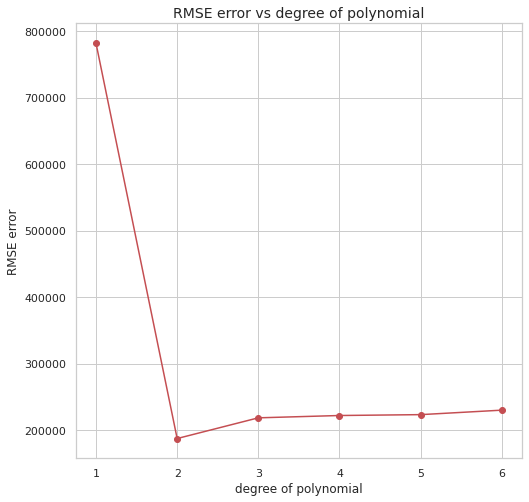

In [0]:
fig,axes = plt.subplots(1,1,figsize=(8,8))
fig.set()
axes.plot(range(1,7),[E_rmse1,E_rmse2,E_rmse3,E_rmse4,E_rmse5,E_rmse6],'ro-')
axes.set_xlabel('degree of polynomial')
axes.set_ylabel('RMSE error')
axes.set_title('RMSE error vs degree of polynomial',fontdict={'fontsize':14})
fig.show()

### Bayesian Ridge Regression (Assume Beta prior for initialization of weights and bias)

Still, we choose the model which yields the lowest RMSE error.

In [0]:
#model1
#Set up first degree polynomial feature, transform data to 2D data
poly_r_1 = PolynomialFeatures(1,interaction_only=False,include_bias=True)
x_train_US_transformed_1 = poly_r_1.fit_transform(x_train_US)
x_test_US_transformed_1 = poly_r_1.fit_transform(x_test_US)

# Initialize parameters that needs to be explored for optimization of the model
alpha_1 = [1e-3,1e-2,1e-1,1,2]
alpha_2 = [1e-3,1e-2,1e-1,1,2]
lambda_1 = [ 1e-3,1e-2,1e-1,1,2]
lambda_2 = [1e-3,1e-2,1e-1,1,2]
tol = [1e-6,1e-5,1e-4,1e-3]

# Set up grid
bayesian_grid = {'alpha_1': alpha_1, 'alpha_2' : alpha_2, 'lambda_1': lambda_1, 
                 'lambda_2' : lambda_2,'tol':tol}

#Set up bayesian regressor
bayesian = BayesianRidge()
# Use GridSearchCV to explore the best set of parameters
bayesian_search = GridSearchCV(estimator = bayesian, param_grid = bayesian_grid,scoring='neg_root_mean_squared_error',
                               verbose=1,n_jobs=-1)
bayesian_search.fit(x_train_US_transformed_1, y_train_US)
#print out the parameters of the best estimator
print('The parameter set for the best estimator:',bayesian_search.best_params_)
# Set up the best estimator
bayesian_confirmed_1 = bayesian_search.best_estimator_



#model2
#Set up first degree polynomial feature, transform data to 2D data
poly_r_2 = PolynomialFeatures(2,interaction_only=False,include_bias=True)
x_train_US_transformed_2 = poly_r_2.fit_transform(x_train_US)
x_test_US_transformed_2 = poly_r_2.fit_transform(x_test_US)

# Initialize parameters that needs to be explored for optimization of the model
alpha_1 = [1e-3,1e-2,1e-1,1,2]
alpha_2 = [1e-3,1e-2,1e-1,1,2]
lambda_1 = [ 1e-3,1e-2,1e-1,1,2]
lambda_2 = [1e-3,1e-2,1e-1,1,2]
tol = [1e-6,1e-5,1e-4,1e-3]

# Set up grid
bayesian_grid = {'alpha_1': alpha_1, 'alpha_2' : alpha_2, 'lambda_1': lambda_1, 
                 'lambda_2' : lambda_2,'tol':tol}

#Set up bayesian regressor
bayesian = BayesianRidge()
# Use GridSearchCV to explore the best set of parameters
bayesian_search = GridSearchCV(estimator = bayesian, param_grid = bayesian_grid,scoring='neg_root_mean_squared_error',
                               verbose=1,n_jobs=-1)
bayesian_search.fit(x_train_US_transformed_2, y_train_US)
#print out the parameters of the best estimator
print('The parameter set for the best estimator:',bayesian_search.best_params_)
# Set up the best estimator
bayesian_confirmed_2 = bayesian_search.best_estimator_


#model3
#Set up third degree polynomial feature, transform data to 2D data
poly_r_3 = PolynomialFeatures(3,interaction_only=False,include_bias=True)
x_train_US_transformed_3 = poly_r_3.fit_transform(x_train_US)
x_test_US_transformed_3 = poly_r_3.fit_transform(x_test_US)

# Initialize parameters that needs to be explored for optimization of the model
alpha_1 = [1e-3,1e-2,1e-1,1,2]
alpha_2 = [1e-3,1e-2,1e-1,1,2]
lambda_1 = [ 1e-3,1e-2,1e-1,1,2]
lambda_2 = [1e-3,1e-2,1e-1,1,2]
tol = [1e-6,1e-5,1e-4,1e-3]

# Set up grid
bayesian_grid = {'alpha_1': alpha_1, 'alpha_2' : alpha_2, 'lambda_1': lambda_1, 
                 'lambda_2' : lambda_2,'tol':tol}

#Set up bayesian regressor
bayesian = BayesianRidge()
# Use GridSearchCV to explore the best set of parameters
bayesian_search = GridSearchCV(estimator = bayesian, param_grid = bayesian_grid,scoring='neg_root_mean_squared_error',
                               verbose=1,n_jobs=-1)
bayesian_search.fit(x_train_US_transformed_3, y_train_US)
#print out the parameters of the best estimator
print('The parameter set for the best estimator:',bayesian_search.best_params_)
# Set up the best estimator
bayesian_confirmed_3 = bayesian_search.best_estimator_



#model4
#Set up fourth degree polynomial feature, transform data to 5D data
poly_r_4 = PolynomialFeatures(4,interaction_only=False,include_bias=True)
x_train_US_transformed_4 = poly_r_4.fit_transform(x_train_US)
x_test_US_transformed_4 = poly_r_4.fit_transform(x_test_US)

# Initialize parameters that needs to be explored for optimization of the model
alpha_1 = [1e-3,1e-2,1e-1,1,2]
alpha_2 = [1e-3,1e-2,1e-1,1,2]
lambda_1 = [ 1e-3,1e-2,1e-1,1,2]
lambda_2 = [1e-3,1e-2,1e-1,1,2]
tol = [1e-6,1e-5,1e-4,1e-3]

# Set up grid
bayesian_grid = {'alpha_1': alpha_1, 'alpha_2' : alpha_2, 'lambda_1': lambda_1, 
                 'lambda_2' : lambda_2,'tol':tol}

#Set up bayesian regressor
bayesian = BayesianRidge()
# Use GridSearchCV to explore the best set of parameters
bayesian_search = GridSearchCV(estimator = bayesian, param_grid = bayesian_grid,scoring='neg_root_mean_squared_error',
                               verbose=1,n_jobs=-1)
bayesian_search.fit(x_train_US_transformed_4, y_train_US)
#print out the parameters of the best estimator
print('The parameter set for the best estimator:',bayesian_search.best_params_)
# Set up the best estimator
bayesian_confirmed_4 = bayesian_search.best_estimator_



#model5
#Set up first degree polynomial feature, transform data to 2D data
poly_r_5 = PolynomialFeatures(5,interaction_only=False,include_bias=True)
x_train_US_transformed_5 = poly_r_5.fit_transform(x_train_US)
x_test_US_transformed_5 = poly_r_5.fit_transform(x_test_US)

# Initialize parameters that needs to be explored for optimization of the model
alpha_1 = [1e-3,1e-2,1e-1,1,2]
alpha_2 = [1e-3,1e-2,1e-1,1,2]
lambda_1 = [ 1e-3,1e-2,1e-1,1,2]
lambda_2 = [1e-3,1e-2,1e-1,1,2]
tol = [1e-6,1e-5,1e-4,1e-3]

# Set up grid
bayesian_grid = {'alpha_1': alpha_1, 'alpha_2' : alpha_2, 'lambda_1': lambda_1, 
                 'lambda_2' : lambda_2,'tol':tol}

#Set up bayesian regressor
bayesian = BayesianRidge()
# Use GridSearchCV to explore the best set of parameters
bayesian_search = GridSearchCV(estimator = bayesian, param_grid = bayesian_grid,scoring='neg_root_mean_squared_error',
                               verbose=1,n_jobs=-1)
bayesian_search.fit(x_train_US_transformed_5, y_train_US)
#print out the parameters of the best estimator
print('The parameter set for the best estimator:',bayesian_search.best_params_)
# Set up the best estimator
bayesian_confirmed_5 = bayesian_search.best_estimator_



#model6
#Set up first degree polynomial feature, transform data to 2D data
poly_r_6 = PolynomialFeatures(6,interaction_only=False,include_bias=True)
x_train_US_transformed_6 = poly_r_6.fit_transform(x_train_US)
x_test_US_transformed_6 = poly_r_6.fit_transform(x_test_US)

# Initialize parameters that needs to be explored for optimization of the model
alpha_1 = [1e-3,1e-2,1e-1,1,2]
alpha_2 = [1e-3,1e-2,1e-1,1,2]
lambda_1 = [ 1e-3,1e-2,1e-1,1,2]
lambda_2 = [1e-3,1e-2,1e-1,1,2]
tol = [1e-6,1e-5,1e-4,1e-3]

# Set up grid
bayesian_grid = {'alpha_1': alpha_1, 'alpha_2' : alpha_2, 'lambda_1': lambda_1, 
                 'lambda_2' : lambda_2,'tol':tol}

#Set up bayesian regressor
bayesian = BayesianRidge()
# Use GridSearchCV to explore the best set of parameters
bayesian_search = GridSearchCV(estimator = bayesian, param_grid = bayesian_grid,scoring='neg_root_mean_squared_error',
                               verbose=1,n_jobs=-1)
bayesian_search.fit(x_train_US_transformed_6, y_train_US)
#print out the parameters of the best estimator
print('The parameter set for the best estimator:',bayesian_search.best_params_)
# Set up the best estimator
bayesian_confirmed_6 = bayesian_search.best_estimator_

Fitting 5 folds for each of 2500 candidates, totalling 12500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 12500 out of 12500 | elapsed:    6.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


The parameter set for the best estimator: {'alpha_1': 0.1, 'alpha_2': 0.01, 'lambda_1': 0.01, 'lambda_2': 2, 'tol': 1e-06}
Fitting 5 folds for each of 2500 candidates, totalling 12500 fits


[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 9720 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 12500 out of 12500 | elapsed:    9.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


The parameter set for the best estimator: {'alpha_1': 2, 'alpha_2': 0.001, 'lambda_1': 0.001, 'lambda_2': 2, 'tol': 0.001}
Fitting 5 folds for each of 2500 candidates, totalling 12500 fits


[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 12500 out of 12500 | elapsed:    8.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


The parameter set for the best estimator: {'alpha_1': 2, 'alpha_2': 0.001, 'lambda_1': 0.001, 'lambda_2': 2, 'tol': 1e-06}
Fitting 5 folds for each of 2500 candidates, totalling 12500 fits


[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 12500 out of 12500 | elapsed:    7.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


The parameter set for the best estimator: {'alpha_1': 0.001, 'alpha_2': 2, 'lambda_1': 2, 'lambda_2': 2, 'tol': 0.001}
Fitting 5 folds for each of 2500 candidates, totalling 12500 fits


[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 12500 out of 12500 | elapsed:    7.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


The parameter set for the best estimator: {'alpha_1': 0.001, 'alpha_2': 2, 'lambda_1': 1, 'lambda_2': 0.01, 'tol': 0.001}
Fitting 5 folds for each of 2500 candidates, totalling 12500 fits


[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.3s


The parameter set for the best estimator: {'alpha_1': 2, 'alpha_2': 0.1, 'lambda_1': 0.001, 'lambda_2': 2, 'tol': 1e-06}


[Parallel(n_jobs=-1)]: Done 12500 out of 12500 | elapsed:    7.9s finished


Respectively, RMSE errors from first degree to six degree are:  
 523328.93071324454 
 288413.84102827415 
 188700.90616371165 
 319060.2824712581 
 357347.70844982617 
 290542.3442173509


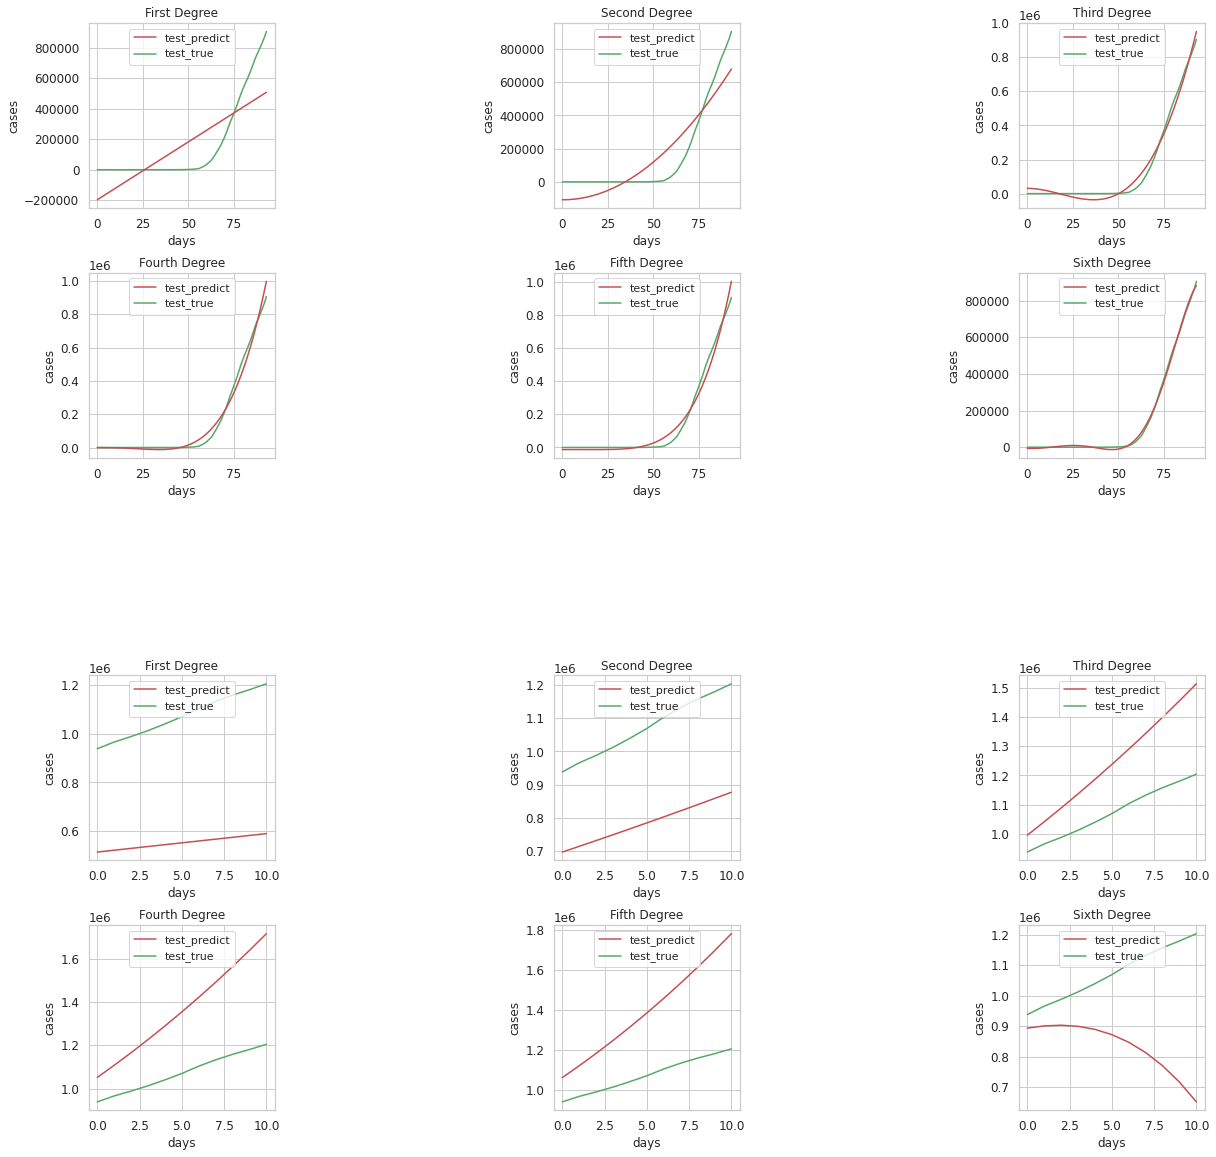

In [0]:
fig = plt.figure(figsize=(20, 20))
outer = gridspec.GridSpec(2, 1, wspace=0.2, hspace=0.5)

#Plot the train data
inner = gridspec.GridSpecFromSubplotSpec(2, 3, subplot_spec=outer[0], wspace=1.5, hspace=0.35)
ax = plt.Subplot(fig,inner[0])
ax.plot(y_train_US,'g-',label='train_true')
ax.plot(bayesian_confirmed_1.predict(x_train_US_transformed_1),'r-',label='train_predict')
ax.legend(handles, labels, loc='upper center')
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('First Degree')
fig.add_subplot(ax)


ax = plt.Subplot(fig,inner[1])
ax.plot(y_train_US,'g-',label='train_true')
ax.plot(bayesian_confirmed_2.predict(x_train_US_transformed_2),'r-',label='train_predict')
ax.legend(handles, labels, loc='upper center')
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Second Degree')
fig.add_subplot(ax)

ax = plt.Subplot(fig,inner[2])
ax.plot(y_train_US,'g-',label='train_true')
ax.plot(bayesian_confirmed_3.predict(x_train_US_transformed_3),'r-',label='train_predict')
ax.legend(handles, labels, loc='upper center')
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Third Degree')
fig.add_subplot(ax)

ax = plt.Subplot(fig,inner[3])
ax.plot(y_train_US,'g-',label='train_true')
ax.plot(bayesian_confirmed_4.predict(x_train_US_transformed_4),'r-',label='train_predict')
ax.legend(handles, labels, loc='upper center')
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Fourth Degree')
fig.add_subplot(ax)

ax = plt.Subplot(fig,inner[4])
ax.plot(y_train_US,'g-',label='train_true')
ax.plot(bayesian_confirmed_5.predict(x_train_US_transformed_5),'r-',label='train_predict')
ax.legend(handles, labels, loc='upper center')
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Fifth Degree')
fig.add_subplot(ax)

ax = plt.Subplot(fig,inner[5])
ax.plot(y_train_US,'g-',label='train_true')
ax.plot(bayesian_confirmed_6.predict(x_train_US_transformed_6),'r-',label='train_predict')
ax.legend(handles, labels, loc='upper center')
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Sixth Degree')
fig.add_subplot(ax)

#Plot the prediction
inner = gridspec.GridSpecFromSubplotSpec(2, 3, subplot_spec=outer[1], wspace=1.5, hspace=0.35)

# Use the best estimator to do the prediction
y_pred_US_1 = bayesian_confirmed_1.predict(x_test_US_transformed_1)
BR_rmse1 = mean_squared_error(y_test_US, y_pred_US_1,squared=False)
ax = plt.Subplot(fig,inner[0])
ax.plot(y_test_US,'g-',label='test_true')
ax.plot(y_pred_US_1,'r-',label='test_predict')
ax.legend(handles, labels, loc='upper center')
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('First Degree')
fig.add_subplot(ax)

# Use the best estimator to do the prediction
y_pred_US_2 = bayesian_confirmed_2.predict(x_test_US_transformed_2)
BR_rmse2 = mean_squared_error(y_test_US, y_pred_US_2,squared=False)
ax = plt.Subplot(fig,inner[1])
ax.plot(y_test_US,'g-',label='test_true')
ax.plot(y_pred_US_2,'r-',label='test_predict')
ax.legend(handles, labels, loc='upper center')
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Second Degree')
fig.add_subplot(ax)


# Use the best estimator to do the prediction
y_pred_US_3 = bayesian_confirmed_3.predict(x_test_US_transformed_3)
BR_rmse3 = mean_squared_error(y_test_US, y_pred_US_3,squared=False)
ax = plt.Subplot(fig,inner[2])
ax.plot(y_test_US,'g-',label='test_true')
ax.plot(y_pred_US_3,'r-',label='test_predict')
ax.legend(handles, labels, loc='upper center')
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Third Degree')
fig.add_subplot(ax)


# Use the best estimator to do the prediction
y_pred_US_4 = bayesian_confirmed_4.predict(x_test_US_transformed_4)
BR_rmse4 = mean_squared_error(y_test_US, y_pred_US_4,squared=False)
ax = plt.Subplot(fig,inner[3])
ax.plot(y_test_US,'g-',label='test_true')
ax.plot(y_pred_US_4,'r-',label='test_predict')
ax.legend(handles, labels, loc='upper center')
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Fourth Degree')
fig.add_subplot(ax)

# Use the best estimator to do the prediction
y_pred_US_5 = bayesian_confirmed_5.predict(x_test_US_transformed_5)
BR_rmse5 = mean_squared_error(y_test_US, y_pred_US_5,squared=False)
ax = plt.Subplot(fig,inner[4])
ax.plot(y_test_US,'g-',label='test_true')
ax.plot(y_pred_US_5,'r-',label='test_predict')
ax.legend(handles, labels, loc='upper center')
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Fifth Degree')
fig.add_subplot(ax)

# Use the best estimator to do the prediction
y_pred_US_6 = bayesian_confirmed_6.predict(x_test_US_transformed_6)
BR_rmse6 = mean_squared_error(y_test_US, y_pred_US_6,squared=False)
ax = plt.Subplot(fig,inner[5])
ax.plot(y_test_US,'g-',label='test_true')
ax.plot(y_pred_US_6,'r-',label='test_predict')
ax.legend(handles, labels, loc='upper center')
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Sixth Degree')
fig.add_subplot(ax)
fig.show()
print('Respectively, RMSE errors from first degree to six degree are: ','\n',BR_rmse1,'\n',BR_rmse2,'\n',BR_rmse3,'\n',BR_rmse4,'\n',BR_rmse5,'\n',BR_rmse6)

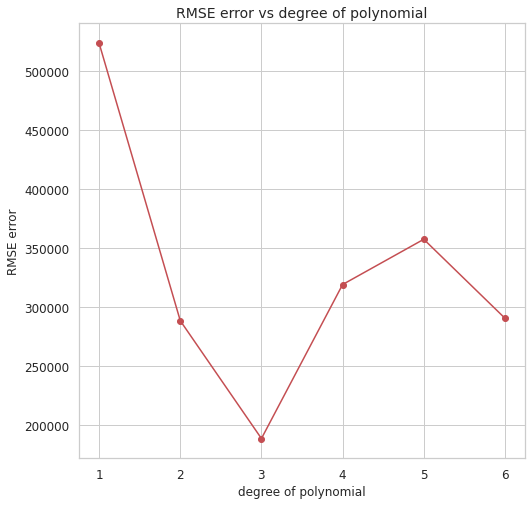

In [0]:
fig,axes = plt.subplots(1,1,figsize=(8,8))
fig.set()
axes.plot(range(1,7),[BR_rmse1,BR_rmse2,BR_rmse3,BR_rmse4,BR_rmse5,BR_rmse6],'ro-')
axes.set_xlabel('degree of polynomial')
axes.set_ylabel('RMSE error')
axes.set_title('RMSE error vs degree of polynomial',fontdict={'fontsize':14})
fig.show()

### Huber Regression (Stress the importance of outliers in this dataset)

Still, we choose the model which yields the lowest RMSE error.

In [0]:
#model1
#Set up first degree polynomial feature, transform data to 2D data
poly_H_1 = PolynomialFeatures(1,interaction_only=False,include_bias=True)
x_train_US_transformed_1 = poly_H_1.fit_transform(x_train_US)
x_test_US_transformed_1 = poly_H_1.fit_transform(x_test_US)
# Initialize parameters that needs to be explored for optimization of the model
epsilon = [2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7]
alpha = [1e-8,1e-7,1e-6,1e-5,1e-1,1,2,10,15]
warm_start=[True,False]
tol = [1e-6,1e-4,1e-5]

# Set up grid
Huber_grid = {'epsilon': epsilon, 'alpha' : alpha,'tol':tol,'warm_start':warm_start}

#Set up bayesian regressor
Huber_regressor = HuberRegressor()
# Use GridSearchCV to explore the best set of parameters
Huber_search = GridSearchCV(estimator = Huber_regressor, param_grid = Huber_grid,scoring='neg_root_mean_squared_error',
                               verbose=1,n_jobs=-1)
Huber_search.fit(x_train_US_transformed_1, y_train_US)
#print out the parameters of the best estimator
print('The parameter set for the best estimator:',Huber_search.best_params_)
# Set up the best estimator
Huber_confirmed_1 = Huber_search.best_estimator_

#model2
#Set up first degree polynomial feature, transform data to 2D data
poly_H_2 = PolynomialFeatures(2,interaction_only=False,include_bias=True)
x_train_US_transformed_2 = poly_H_2.fit_transform(x_train_US)
x_test_US_transformed_2 = poly_H_2.fit_transform(x_test_US)

# Initialize parameters that needs to be explored for optimization of the model
epsilon = [2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7]
alpha = [1e-8,1e-7,1e-6,1e-5,1e-1,1,2,10,15]
warm_start=[True,False]
tol = [1e-6,1e-4,1e-5]

# Set up grid
Huber_grid = {'epsilon': epsilon, 'alpha' : alpha,'tol':tol,'warm_start':warm_start}

#Set up bayesian regressor
Huber_regressor = HuberRegressor()
# Use GridSearchCV to explore the best set of parameters
Huber_search = GridSearchCV(estimator = Huber_regressor, param_grid = Huber_grid,scoring='neg_root_mean_squared_error',
                               verbose=1,n_jobs=-1)
Huber_search.fit(x_train_US_transformed_2, y_train_US)
#print out the parameters of the best estimator
print('The parameter set for the best estimator:',Huber_search.best_params_)
# Set up the best estimator
Huber_confirmed_2 = Huber_search.best_estimator_

#model3
#Set up first degree polynomial feature, transform data to 2D data
poly_H_3 = PolynomialFeatures(3,interaction_only=False,include_bias=True)
x_train_US_transformed_3 = poly_H_3.fit_transform(x_train_US)
x_test_US_transformed_3 = poly_H_3.fit_transform(x_test_US)

# Initialize parameters that needs to be explored for optimization of the model
epsilon = [2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7]
alpha = [1e-8,1e-7,1e-6,1e-5,1e-1,1,2,10,15]
warm_start=[True,False]
tol = [1e-6,1e-4,1e-5]

# Set up grid
Huber_grid = {'epsilon': epsilon, 'alpha' : alpha,'tol':tol,'warm_start':warm_start}

#Set up bayesian regressor
Huber_regressor = HuberRegressor()
# Use GridSearchCV to explore the best set of parameters
Huber_search = GridSearchCV(estimator = Huber_regressor, param_grid = Huber_grid,scoring='neg_root_mean_squared_error',
                               verbose=1,n_jobs=-1)
Huber_search.fit(x_train_US_transformed_3, y_train_US)
#print out the parameters of the best estimator
print('The parameter set for the best estimator:',Huber_search.best_params_)
# Set up the best estimator
Huber_confirmed_3 = Huber_search.best_estimator_

#model4
#Set up first degree polynomial feature, transform data to 2D data
poly_H_4 = PolynomialFeatures(4,interaction_only=False,include_bias=True)
x_train_US_transformed_4 = poly_H_4.fit_transform(x_train_US)
x_test_US_transformed_4 = poly_H_4.fit_transform(x_test_US)

# Initialize parameters that needs to be explored for optimization of the model
epsilon = [2,2.5,3,3.5,4,4.5,5]
alpha = [1e-8,1e-7,1e-6,1e-5,1e-1]
warm_start=[True,False]
tol = [1e-6,1e-4,1e-5]

# Set up grid
Huber_grid = {'epsilon': epsilon, 'alpha' : alpha,'tol':tol,'warm_start':warm_start}

#Set up bayesian regressor
Huber_regressor = HuberRegressor()
# Use GridSearchCV to explore the best set of parameters
Huber_search = GridSearchCV(estimator = Huber_regressor, param_grid = Huber_grid,scoring='neg_root_mean_squared_error',
                               verbose=1,n_jobs=-1)
Huber_search.fit(x_train_US_transformed_4, y_train_US)
#print out the parameters of the best estimator
print('The parameter set for the best estimator:',Huber_search.best_params_)
# Set up the best estimator
Huber_confirmed_4 = Huber_search.best_estimator_

#model5
#Set up first degree polynomial feature, transform data to 2D data
poly_H_5 = PolynomialFeatures(5,interaction_only=False,include_bias=True)
x_train_US_transformed_5 = poly_H_5.fit_transform(x_train_US)
x_test_US_transformed_5 = poly_H_5.fit_transform(x_test_US)

# Initialize parameters that needs to be explored for optimization of the model
epsilon = [2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7]
alpha = [1e-8,1e-7,1e-6,1e-5,1e-1,1,2,10,15]
warm_start=[True,False]
tol = [1e-6,1e-4,1e-5]

# Set up grid
Huber_grid = {'epsilon': epsilon, 'alpha' : alpha,'tol':tol,'warm_start':warm_start}

#Set up bayesian regressor
Huber_regressor = HuberRegressor()
# Use GridSearchCV to explore the best set of parameters
Huber_search = GridSearchCV(estimator = Huber_regressor, param_grid = Huber_grid,scoring='neg_root_mean_squared_error',
                               verbose=1,n_jobs=-1)
Huber_search.fit(x_train_US_transformed_5, y_train_US)
#print out the parameters of the best estimator
print('The parameter set for the best estimator:',Huber_search.best_params_)
# Set up the best estimator
Huber_confirmed_5 = Huber_search.best_estimator_

#model6
#Set up first degree polynomial feature, transform data to 2D data
poly_H_6 = PolynomialFeatures(6,interaction_only=False,include_bias=True)
x_train_US_transformed_6 = poly_H_6.fit_transform(x_train_US)
x_test_US_transformed_6 = poly_H_6.fit_transform(x_test_US)

# Initialize parameters that needs to be explored for optimization of the model
epsilon = [2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7]
alpha = [1e-8,1e-7,1e-6,1e-5,1e-1,1,2,10,15]
warm_start=[True,False]
tol = [1e-6,1e-4,1e-5]

# Set up grid
Huber_grid = {'epsilon': epsilon, 'alpha' : alpha,'tol':tol,'warm_start':warm_start}

#Set up bayesian regressor
Huber_regressor = HuberRegressor()
# Use GridSearchCV to explore the best set of parameters
Huber_search = GridSearchCV(estimator = Huber_regressor, param_grid = Huber_grid,scoring='neg_root_mean_squared_error',
                               verbose=1,n_jobs=-1)
Huber_search.fit(x_train_US_transformed_6, y_train_US)
#print out the parameters of the best estimator
print('The parameter set for the best estimator:',Huber_search.best_params_)
# Set up the best estimator
Huber_confirmed_6 = Huber_search.best_estimator_

Fitting 5 folds for each of 594 candidates, totalling 2970 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 2680 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 2970 out of 2970 | elapsed:    8.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


The parameter set for the best estimator: {'alpha': 0.1, 'epsilon': 5.5, 'tol': 1e-06, 'warm_start': True}
Fitting 5 folds for each of 594 candidates, totalling 2970 fits


[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1400 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 2970 out of 2970 | elapsed:   16.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


The parameter set for the best estimator: {'alpha': 0.1, 'epsilon': 6, 'tol': 1e-06, 'warm_start': True}
Fitting 5 folds for each of 594 candidates, totalling 2970 fits


[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 1400 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 2970 out of 2970 | elapsed:   18.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


The parameter set for the best estimator: {'alpha': 1e-06, 'epsilon': 7, 'tol': 1e-06, 'warm_start': True}
Fitting 5 folds for each of 210 candidates, totalling 1050 fits


[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1050 out of 1050 | elapsed:    7.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


The parameter set for the best estimator: {'alpha': 1e-07, 'epsilon': 2.5, 'tol': 1e-06, 'warm_start': True}
Fitting 5 folds for each of 594 candidates, totalling 2970 fits


[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 1400 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 2970 out of 2970 | elapsed:   24.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


The parameter set for the best estimator: {'alpha': 1e-05, 'epsilon': 2, 'tol': 1e-06, 'warm_start': True}
Fitting 5 folds for each of 594 candidates, totalling 2970 fits


[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1400 tasks      | elapsed:   10.8s


The parameter set for the best estimator: {'alpha': 0.1, 'epsilon': 2, 'tol': 1e-06, 'warm_start': True}


[Parallel(n_jobs=-1)]: Done 2970 out of 2970 | elapsed:   21.9s finished


Respectively, RMSE errors from first degree to six degree are:  
 598392.1678000779 
 210584.36062118542 
 146748.4102893734 
 418956.03997807123 
 525410.1413574559 
 88843.92027309175


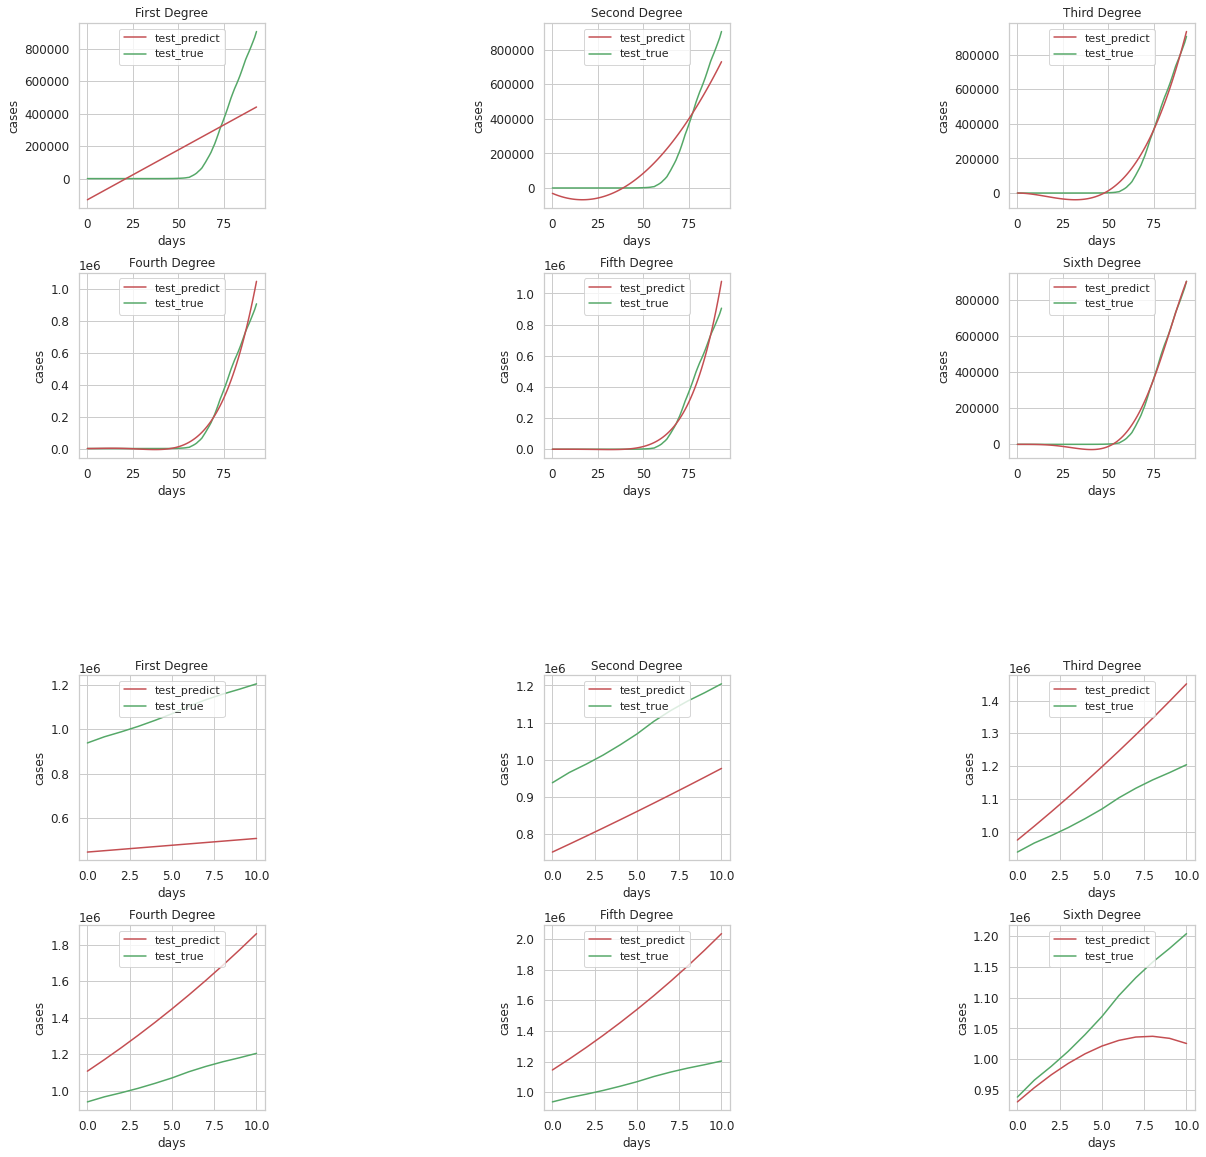

In [0]:
fig = plt.figure(figsize=(20, 20))
outer = gridspec.GridSpec(2, 1, wspace=0.2, hspace=0.5)

#Plot the train data
inner = gridspec.GridSpecFromSubplotSpec(2, 3, subplot_spec=outer[0], wspace=1.5, hspace=0.35)
ax = plt.Subplot(fig,inner[0])
ax.plot(y_train_US,'g-',label='train_true')
ax.plot(Huber_confirmed_1.predict(x_train_US_transformed_1),'r-',label='train_predict')
ax.legend(handles, labels, loc='upper center')
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('First Degree')
fig.add_subplot(ax)


ax = plt.Subplot(fig,inner[1])
ax.plot(y_train_US,'g-',label='train_true')
ax.plot(Huber_confirmed_2.predict(x_train_US_transformed_2),'r-',label='train_predict')
ax.legend(handles, labels, loc='upper center')
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Second Degree')
fig.add_subplot(ax)

ax = plt.Subplot(fig,inner[2])
ax.plot(y_train_US,'g-',label='train_true')
ax.plot(Huber_confirmed_3.predict(x_train_US_transformed_3),'r-',label='train_predict')
ax.legend(handles, labels, loc='upper center')
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Third Degree')
fig.add_subplot(ax)

ax = plt.Subplot(fig,inner[3])
ax.plot(y_train_US,'g-',label='train_true')
ax.plot(Huber_confirmed_4.predict(x_train_US_transformed_4),'r-',label='train_predict')
ax.legend(handles, labels, loc='upper center')
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Fourth Degree')
fig.add_subplot(ax)

ax = plt.Subplot(fig,inner[4])
ax.plot(y_train_US,'g-',label='train_true')
ax.plot(Huber_confirmed_5.predict(x_train_US_transformed_5),'r-',label='train_predict')
ax.legend(handles, labels, loc='upper center')
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Fifth Degree')
fig.add_subplot(ax)

ax = plt.Subplot(fig,inner[5])
ax.plot(y_train_US,'g-',label='train_true')
ax.plot(Huber_confirmed_6.predict(x_train_US_transformed_6),'r-',label='train_predict')
ax.legend(handles, labels, loc='upper center')
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Sixth Degree')
fig.add_subplot(ax)

#Plot the prediction
inner = gridspec.GridSpecFromSubplotSpec(2, 3, subplot_spec=outer[1], wspace=1.5, hspace=0.35)

# Use the best estimator to do the prediction
y_pred_US_1 = Huber_confirmed_1.predict(x_test_US_transformed_1)
H_rmse1 = mean_squared_error(y_test_US, y_pred_US_1,squared=False)
ax = plt.Subplot(fig,inner[0])
ax.plot(y_test_US,'g-',label='test_true')
ax.plot(y_pred_US_1,'r-',label='test_predict')
ax.legend(handles, labels, loc='upper center')
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('First Degree')
fig.add_subplot(ax)

# Use the best estimator to do the prediction
y_pred_US_2 = Huber_confirmed_2.predict(x_test_US_transformed_2)
H_rmse2 = mean_squared_error(y_test_US, y_pred_US_2,squared=False)
ax = plt.Subplot(fig,inner[1])
ax.plot(y_test_US,'g-',label='test_true')
ax.plot(y_pred_US_2,'r-',label='test_predict')
ax.legend(handles, labels, loc='upper center')
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Second Degree')
fig.add_subplot(ax)


# Use the best estimator to do the prediction
y_pred_US_3 = Huber_confirmed_3.predict(x_test_US_transformed_3)
H_rmse3 = mean_squared_error(y_test_US, y_pred_US_3,squared=False)
ax = plt.Subplot(fig,inner[2])
ax.plot(y_test_US,'g-',label='test_true')
ax.plot(y_pred_US_3,'r-',label='test_predict')
ax.legend(handles, labels, loc='upper center')
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Third Degree')
fig.add_subplot(ax)


# Use the best estimator to do the prediction
y_pred_US_4 = Huber_confirmed_4.predict(x_test_US_transformed_4)
H_rmse4 = mean_squared_error(y_test_US, y_pred_US_4,squared=False)
ax = plt.Subplot(fig,inner[3])
ax.plot(y_test_US,'g-',label='test_true')
ax.plot(y_pred_US_4,'r-',label='test_predict')
ax.legend(handles, labels, loc='upper center')
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Fourth Degree')
fig.add_subplot(ax)

# Use the best estimator to do the prediction
y_pred_US_5 = Huber_confirmed_5.predict(x_test_US_transformed_5)
H_rmse5 = mean_squared_error(y_test_US, y_pred_US_5,squared=False)
ax = plt.Subplot(fig,inner[4])
ax.plot(y_test_US,'g-',label='test_true')
ax.plot(y_pred_US_5,'r-',label='test_predict')
ax.legend(handles, labels, loc='upper center')
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Fifth Degree')
fig.add_subplot(ax)

# Use the best estimator to do the prediction
y_pred_US_6 = Huber_confirmed_6.predict(x_test_US_transformed_6)
H_rmse6 = mean_squared_error(y_test_US, y_pred_US_6,squared=False)
ax = plt.Subplot(fig,inner[5])
ax.plot(y_test_US,'g-',label='test_true')
ax.plot(y_pred_US_6,'r-',label='test_predict')
ax.legend(handles, labels, loc='upper center')
ax.set_xlabel('days')
ax.set_ylabel('cases')
ax.set_title('Sixth Degree')
fig.add_subplot(ax)
fig.show()
print('Respectively, RMSE errors from first degree to six degree are: ','\n',H_rmse1,'\n',H_rmse2,'\n',H_rmse3,'\n',H_rmse4,'\n',H_rmse5,'\n',H_rmse6)

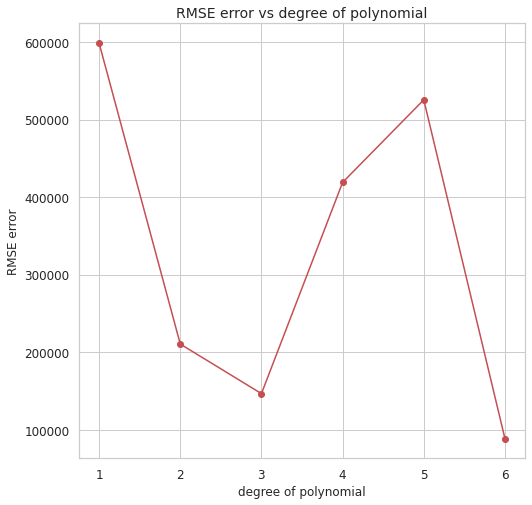

In [0]:
fig,axes = plt.subplots(1,1,figsize=(8,8))
fig.set()
axes.plot(range(1,7),[H_rmse1,H_rmse2,H_rmse3,H_rmse4,H_rmse5,H_rmse6],'ro-')
axes.set_xlabel('degree of polynomial')
axes.set_ylabel('RMSE error')
axes.set_title('RMSE error vs degree of polynomial',fontdict={'fontsize':14})
fig.show()

###Compare regressors

 After choosing the best degree for each regressor, we compare those regressors in order to yield a regressor that can fit the dataset most

[58242.543329365675,
 60254.77529029988,
 140048.68614598853,
 187501.72573149783,
 188700.90616371165,
 88843.92027309175]

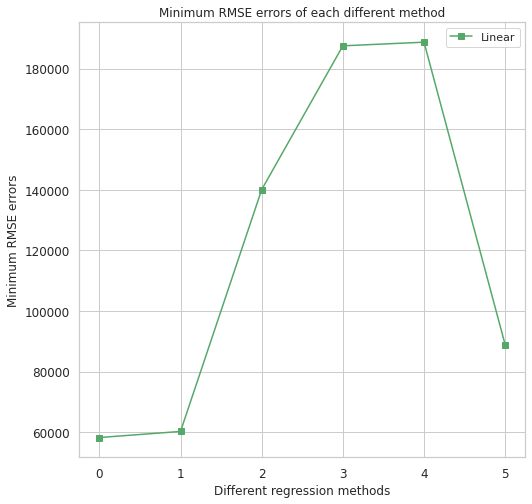

In [0]:
LR_min = sorted([rmse1,rmse2,rmse3,rmse4,rmse5,rmse6])[0]
Lasso_min = sorted([L_rmse1,L_rmse2,L_rmse3,L_rmse4,L_rmse5,L_rmse6])[0]
Ridge_min = sorted([R_rmse1,R_rmse2,R_rmse3,R_rmse4,R_rmse5,R_rmse6])[0]
Elastic_min = sorted([E_rmse1,E_rmse2,E_rmse3,E_rmse4,E_rmse5,E_rmse6])[0]
Bayesian_Ridge_min = sorted([BR_rmse1,BR_rmse2,BR_rmse3,BR_rmse4,BR_rmse5,BR_rmse6])[0]
Huber_min = sorted([H_rmse1,H_rmse2,H_rmse3,H_rmse4,H_rmse5,H_rmse6])[0]

fig,axes = plt.subplots(1,1,figsize=(8,8))
axes.plot(range(6),[LR_min,Lasso_min,Ridge_min,Elastic_min,Bayesian_Ridge_min,Huber_min],'gs-')
axes.set_xlabel('Different regression methods')
axes.set_ylabel('Minimum RMSE errors')
axes.set_title('Minimum RMSE errors of each different method')
axes.legend(['Linear','Lasso','Ridge','Elastic','Bayesian Ridge','Huber'])
fig.show()
[LR_min,Lasso_min,Ridge_min,Elastic_min,Bayesian_Ridge_min,Huber_min]

### Predicition

Use Linear Regression of Degree 2 to predict the data in the coming 10 days

In [0]:
forecast_x_US = np.linspace(x_test_US[-1]+1,x_test_US[-1]+10,10)

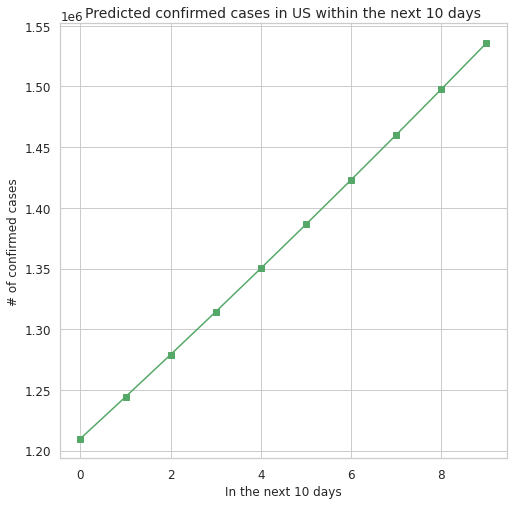

In [0]:
poly_forecast = PolynomialFeatures(2,interaction_only=False,include_bias=True)
x_train_US_transformed = poly_forecast.fit_transform(x_train_US)
forecast_x_US_transformed = poly_forecast.fit_transform(forecast_x_US)


model2 = LinearRegression(normalize=False).fit(x_train_US_transformed_2,y_train_US)

# Use the estimator to do the prediction
forecast_y = model2.predict(forecast_x_US_transformed)

# Plot predicted values vs time 
fig,axes = plt.subplots(1,1,figsize=(8,8))
axes.plot(range(len(forecast_y)),forecast_y,'gs-')
axes.set_xlabel('In the next 10 days')
axes.set_ylabel('# of confirmed cases')
axes.set_title('Predicted confirmed cases in US within the next 10 days',fontdict={'fontsize':14})
fig.show()

**Note: The best regressor may change as time evolves. Therefore, the regressor used for prediction as above should be chosen manually as time evolves.**

##Part III - Explore architectures of Convolutional Neural Networks to classify pneumonia Chest X-rays images

Since the publicly released Chest X-rays images for COVID-19 are not enough to train. We use pneumonia Chest X-rays to train the CNNs. The trained CNNs could be directly used for classifying COVID-19 Chest X-rays images once the public dataset is large enough to be trained, but probably with minor changes in the image pre-preocessing part.

In [0]:
# Use GPU
sal_ = torch.device("cuda:0")
torch.cuda.empty_cache()
G = torch.cuda.is_available()

In [0]:
# Mount google drive
DRIVE_MOUNT='/content/gdrive'
drive.mount(DRIVE_MOUNT,force_remount=True)


# create folder to write data to
CIS545_Final = os.path.join(DRIVE_MOUNT, 'My Drive', 'CIS545_Liang')
os.makedirs(CIS545_Final, exist_ok=True)

Mounted at /content/gdrive


In [0]:
#download images
gdd.download_file_from_google_drive(file_id='1zyoa2wQELSp3ho9Hyy-8FPea0Ttn_YK3',
                                    dest_path='/content/gdrive/My Drive/CIS545_Liang/data.zip')

In [0]:
!unzip "/content/gdrive/My Drive/CIS545_Liang/data.zip"

Streaming output truncated to the last 5000 lines.
  inflating: __MACOSX/chest_xray/images/PNEUMONIA/._BACTERIA-7512869-0002.jpeg  
  inflating: chest_xray/images/PNEUMONIA/VIRUS-9624424-0003.jpeg  
  inflating: __MACOSX/chest_xray/images/PNEUMONIA/._VIRUS-9624424-0003.jpeg  
  inflating: chest_xray/images/PNEUMONIA/BACTERIA-5378466-0001.jpeg  
  inflating: __MACOSX/chest_xray/images/PNEUMONIA/._BACTERIA-5378466-0001.jpeg  
  inflating: chest_xray/images/PNEUMONIA/BACTERIA-4371619-0002.jpeg  
  inflating: __MACOSX/chest_xray/images/PNEUMONIA/._BACTERIA-4371619-0002.jpeg  
  inflating: chest_xray/images/PNEUMONIA/VIRUS-7704214-0002.jpeg  
  inflating: __MACOSX/chest_xray/images/PNEUMONIA/._VIRUS-7704214-0002.jpeg  
  inflating: chest_xray/images/PNEUMONIA/VIRUS-292296-0002.jpeg  
  inflating: __MACOSX/chest_xray/images/PNEUMONIA/._VIRUS-292296-0002.jpeg  
  inflating: chest_xray/images/PNEUMONIA/BACTERIA-5150733-0013.jpeg  
  inflating: __MACOSX/chest_xray/images/PNEUMONIA/._BACTERIA-51

###Image data pre-processing

In [0]:
size_N_x=[]
size_N_y=[]
size_P_x=[]
size_P_y=[]
normal=[]
pneumonia=[]
for path in tqdm(os.listdir('/content/chest_xray/images/NORMAL')):
  img_path = os.path.join('/content/chest_xray/images/NORMAL',path)
  try:
    if img_path.split('/')[-1][-4:] != 'jpeg':
      print('not JPEG')
    img = Image.open(img_path)
    img.verify()
    if img.mode =='P':
      print('image mode is P')
    arr = cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
    shape = arr.shape
    size_N_x.append(shape[0])
    size_N_y.append(shape[1])
    label = np.eye(2)[0]
    arr = cv2.resize(arr,(300,300))
    arr = arr/255
    normal.append((arr,label))
  except Exception:
    print('invalid image')
    print(img_path)

for path in tqdm(os.listdir('/content/chest_xray/images/PNEUMONIA')):
  img_path = os.path.join('/content/chest_xray/images/PNEUMONIA',path)
  try:
    if img_path.split('/')[-1][-4:] != 'jpeg':
      print('not JPEG')
    img = Image.open(img_path)
    img.verify()
    if img.mode =='P':
      print('image mode is P')
    arr = cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
    shape = arr.shape
    size_P_x.append(shape[0])
    size_P_y.append(shape[1])
    label = np.eye(2)[1]
    arr = cv2.resize(arr,(300,300))
    arr = arr/255
    pneumonia.append((arr,label))
  except Exception:
    print('invalid image')
    print(img_path) 


 35%|███▌      | 1516/4274 [00:08<00:15, 173.90it/s]

not JPEG
invalid image
/content/chest_xray/images/PNEUMONIA/.DS_Store


100%|██████████| 4274/4274 [00:23<00:00, 178.25it/s]


In [0]:
dataset=[]
index = np.random.choice(len(pneumonia),len(normal),replace=False)
for tup in normal:
  dataset.append(tup)
for i in index:
  dataset.append(pneumonia[i])

np.random.shuffle(dataset)
length = len(dataset)
train = dataset[:int(0.8*length)]
test = dataset[int(0.8*length):]
# Create minibatches
train = torch.utils.data.DataLoader(train,batch_size=128)
test = torch.utils.data.DataLoader(test,batch_size=9999)

In [0]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.size = 64
        self.hidden = 50
        self.k = np.array([[2,2],[5,5]])
        self.out = 2
        self.conv1 = nn.Conv2d(1,4,3,3,10) 
        self.conv2 = nn.Conv2d(4,8,4,3,10)
        self.conv3 = nn.Conv2d(8,16,3,3,10)
        self.conv4 = nn.Conv2d(16,32,3,2,10)
        self.conv5 = nn.Conv2d(32,64,3,1)
        self.fc1 = nn.Linear(self.size,self.hidden)
        self.fc2 = nn.Linear(self.hidden,self.hidden)
        self.fc3 = nn.Linear(self.hidden,self.out)
    def convs(self,x):
        x = F.max_pool2d(F.relu(self.conv1(x)),self.k[1,0]) 
        x = F.max_pool2d(F.relu(self.conv2(x)),self.k[1,0]) 
        x = F.max_pool2d(F.relu(self.conv3(x)),self.k[1,0]) 
        x = F.max_pool2d(F.relu(self.conv4(x)),self.k[0,0]) 
        x = F.max_pool2d(F.relu(self.conv5(x)),self.k[0,0])
        return x
    def forward(self,x,flag):
        x = self.convs(x) 
        if flag == True:
          x = x.view(-1,64) 
        else:
          x = x.view(1,self.size) 
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = F.softmax(self.fc3(x),dim=1) 
        return x

### TRAIN

In [0]:
if G == True: net = Net().to(sal_) 
else: net=Net()
optimizer = optim.Adam(net.parameters(),lr=0.001)
loss = nn.MSELoss()
epoch_loss_lst=[]
epochs =300
for epoch in tqdm(range(epochs)):
  for image,label in train:
    net.zero_grad()
    if G == True:
      image = image.view(-1,1,300,300).type(torch.FloatTensor).to(sal_)
      label = label.type(torch.FloatTensor).to(sal_)
    else:
      image = image.view(-1,1,300,300).type(torch.FloatTensor)
      label = label.type(torch.FloatTensor)
    output = net.forward(image,flag=True)
    batch_loss = loss(output,label)
    batch_loss.backward()
    optimizer.step()
  epoch_loss_lst.append(batch_loss)
  if epoch%20 == 0:
    print('Epoch:',epoch,'Loss:',batch_loss)

  0%|          | 1/300 [00:00<04:14,  1.18it/s]

Epoch: 0 Loss: tensor(0.2499, device='cuda:0', grad_fn=<MseLossBackward>)


  7%|▋         | 21/300 [00:17<03:48,  1.22it/s]

Epoch: 20 Loss: tensor(0.0703, device='cuda:0', grad_fn=<MseLossBackward>)


 14%|█▎        | 41/300 [00:33<03:30,  1.23it/s]

Epoch: 40 Loss: tensor(0.0508, device='cuda:0', grad_fn=<MseLossBackward>)


 20%|██        | 61/300 [00:49<03:12,  1.24it/s]

Epoch: 60 Loss: tensor(0.0352, device='cuda:0', grad_fn=<MseLossBackward>)


 27%|██▋       | 81/300 [01:05<02:59,  1.22it/s]

Epoch: 80 Loss: tensor(0.0274, device='cuda:0', grad_fn=<MseLossBackward>)


 34%|███▎      | 101/300 [01:21<02:40,  1.24it/s]

Epoch: 100 Loss: tensor(0.0331, device='cuda:0', grad_fn=<MseLossBackward>)


 40%|████      | 121/300 [01:38<02:25,  1.23it/s]

Epoch: 120 Loss: tensor(0.0335, device='cuda:0', grad_fn=<MseLossBackward>)


 47%|████▋     | 141/300 [01:54<02:10,  1.22it/s]

Epoch: 140 Loss: tensor(0.0273, device='cuda:0', grad_fn=<MseLossBackward>)


 54%|█████▎    | 161/300 [02:10<01:47,  1.29it/s]

Epoch: 160 Loss: tensor(0.0466, device='cuda:0', grad_fn=<MseLossBackward>)


 60%|██████    | 181/300 [02:25<01:32,  1.28it/s]

Epoch: 180 Loss: tensor(0.0283, device='cuda:0', grad_fn=<MseLossBackward>)


 67%|██████▋   | 201/300 [02:41<01:17,  1.28it/s]

Epoch: 200 Loss: tensor(0.0299, device='cuda:0', grad_fn=<MseLossBackward>)


 74%|███████▎  | 221/300 [02:57<01:01,  1.27it/s]

Epoch: 220 Loss: tensor(0.0245, device='cuda:0', grad_fn=<MseLossBackward>)


 80%|████████  | 241/300 [03:12<00:46,  1.27it/s]

Epoch: 240 Loss: tensor(0.0225, device='cuda:0', grad_fn=<MseLossBackward>)


 87%|████████▋ | 261/300 [03:28<00:30,  1.29it/s]

Epoch: 260 Loss: tensor(0.0664, device='cuda:0', grad_fn=<MseLossBackward>)


 94%|█████████▎| 281/300 [03:44<00:15,  1.26it/s]

Epoch: 280 Loss: tensor(0.0202, device='cuda:0', grad_fn=<MseLossBackward>)


100%|██████████| 300/300 [03:59<00:00,  1.25it/s]


### Show the loss values for training

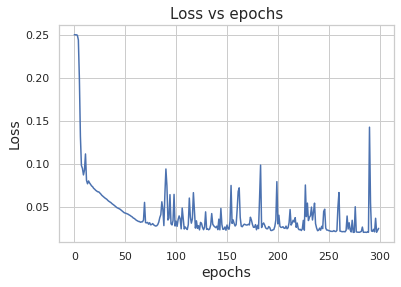

In [0]:
plt.plot(range(epochs),epoch_loss_lst)
plt.xlabel('epochs',{'fontsize':14})
plt.ylabel('Loss',{'fontsize':14})
plt.title('Loss vs epochs',{'fontsize':15})
plt.show()

### TEST

In [0]:
  def acc(test_data):
    TN = 0
    TP = 0
    FN = 0
    FP = 0
    accuracy = 0
    case = 0
    with torch.no_grad():
      if test_data == True:
        data = test
      else:
        data = train
      for image, label in data:
        for i in range(len(image)):
          case+=1
          img = image[i].view(-1,1,300,300)
          if G==True: img = img.type(torch.FloatTensor).to(device)
          else: img = img.type(torch.FloatTensor)
          output = net.forward(img,flag=False)
          pred = int(torch.argmax(output))
          true = int(torch.argmax(label[i]))
          if pred == 0:
            if true == 0:
              TN+=1
              accuracy+=1
            if true == 1:
              FN+=1
          if pred == 1:
            if true == 0:
              FP+=1
            if true == 1:
              TP+=1
              accuracy+=1
    confusion_matrix = {'TN':TN,'FP':FP,'FN':FN,'TP':TP}
    accuracy = accuracy/case
    return confusion_matrix, accuracy

In [0]:
print('confusion matrix and accuracy for training dataset:','\n',acc(False))
print('confusion matrix and accuracy for testing dataset:','\n',acc(True))

confusion matrix and accuracy for training dataset: 
 ({'TN': 1257, 'FP': 27, 'FN': 26, 'TP': 1222}, 0.9790679304897314)
confusion matrix and accuracy for testing dataset: 
 ({'TN': 271, 'FP': 28, 'FN': 15, 'TP': 320}, 0.9321766561514195)


### Deeper classification

The model used before can only classify images as normal and pneumonia. Below this model can further classify images as normal, pneumonia - virus and pneumonia - bacteria.

If we use exactly the preprocessing technique as before, then we get a relatively lower accuracy around 70%, since the model is required to capture deeper characteristics in the images. Thereby we introduce image augmentation techniques as well as minor adjustments to the model which can increase accuracy to around 85%.

#### Image data-preprocessing

In [0]:
normal=[]
pneumonia_v=[]
pneumonia_b=[]
for path in tqdm(os.listdir('/content/chest_xray/images/NORMAL')):
  img_path = os.path.join('/content/chest_xray/images/NORMAL',path)
  try:
    if img_path.split('/')[-1][-4:] != 'jpeg':
      print('not JPEG')
    img = Image.open(img_path)
    img.verify()
    if img.mode =='P':
      print('image mode is P')
    arr = cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
    label = np.eye(3)[0]
    arr = cv2.resize(arr,(200,200))
    arr = arr/255
    normal.append((arr,label))
  except Exception:
    print('invalid image')
    print(img_path)

for path in tqdm(os.listdir('/content/chest_xray/images/PNEUMONIA')):
  img_path = os.path.join('/content/chest_xray/images/PNEUMONIA',path)
  try:
    if img_path.split('/')[-1][-4:] != 'jpeg':
      print('not JPEG')
    img = Image.open(img_path)
    img.verify()
    if img.mode =='P':
      print('image mode is P')
    if img_path.split('/')[-1].split('-')[0] == 'VIRUS':
      arr = cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
      label = np.eye(3)[1]
      arr = cv2.resize(arr,(200,200))
      arr = arr/255      
      pneumonia_v.append((arr,label))

    if img_path.split('/')[-1].split('-')[0] == 'BACTERIA':
      arr = cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
      label = np.eye(3)[2]
      arr = cv2.resize(arr,(200,200))
      arr = arr/255
      pneumonia_b.append((arr,label))
  except Exception:
    print('invalid image')
    print(img_path) 


 36%|███▌      | 1525/4274 [00:07<00:14, 190.74it/s]

not JPEG
invalid image
/content/chest_xray/images/PNEUMONIA/.DS_Store


100%|██████████| 4274/4274 [00:22<00:00, 187.77it/s]


In [0]:
dataset=[]
index_n = np.random.choice(len(normal),len(pneumonia_v),replace=False)
index_b = np.random.choice(len(pneumonia_b),len(pneumonia_v),replace=False)
count = 0
for tup in pneumonia_v:
  count+=1
  dataset.append(tup)
  new_arr = cv2.rotate(tup[0],cv2.ROTATE_180)
  new_tup = (new_arr,np.eye(3)[1])
  dataset.append(new_tup)
  if count%15 == 0:
    flip_tup = (np.fliplr(tup[0]).copy(),np.eye(3)[1])
    dataset.append(flip_tup)

count = 0
for i in index_n:
  count+=1
  dataset.append(normal[i])
  new_arr = cv2.rotate(normal[i][0],cv2.ROTATE_90_CLOCKWISE)
  new_tup = (new_arr,np.eye(3)[0])
  dataset.append(new_tup)
  if count%15 == 0:
    flip_tup = (np.fliplr(normal[i][0]).copy(),np.eye(3)[0])
    dataset.append(flip_tup)

count = 0
for i in index_b:
  count += 1
  dataset.append(pneumonia_b[i])
  new_arr = cv2.rotate(pneumonia_b[i][0],cv2.ROTATE_90_COUNTERCLOCKWISE)
  new_tup = (new_arr,np.eye(3)[2])
  dataset.append(new_tup)
  if count%15 == 0:
    flip_tup = (np.fliplr(pneumonia_b[i][0]).copy(),np.eye(3)[2])
    dataset.append(flip_tup)

np.random.shuffle(dataset)
length = len(dataset)
train = dataset[:int(0.8*length)]
test = dataset[int(0.8*length):]
train = torch.utils.data.DataLoader(train,batch_size=128)
test = torch.utils.data.DataLoader(test,batch_size=9999)

In [0]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.size = 64
        self.hidden = 50
        self.k = np.array([[2,2],[5,5]])
        self.out = 3
        self.conv1 = nn.Conv2d(1,4,3,3,10) 
        self.conv2 = nn.Conv2d(4,8,4,3,10)
        self.conv3 = nn.Conv2d(8,16,3,3,10)
        self.conv4 = nn.Conv2d(16,32,3,2,10)
        self.conv5 = nn.Conv2d(32,64,3,1)
        self.fc1 = nn.Linear(self.size,self.hidden)
        self.fc2 = nn.Linear(self.hidden,self.hidden)
        self.fc3 = nn.Linear(self.hidden,self.out)
    def convs(self,x):
        x = F.max_pool2d(F.relu(self.conv1(x)),self.k[1,0]) 
        x = F.max_pool2d(F.relu(self.conv2(x)),self.k[1,0]) 
        x = F.max_pool2d(F.relu(self.conv3(x)),self.k[1,0]) 
        x = F.max_pool2d(F.relu(self.conv4(x)),self.k[0,0]) 
        x = F.max_pool2d(F.relu(self.conv5(x)),self.k[0,0])
        return x
    def forward(self,x,flag):
        x = self.convs(x) 
        if flag == True:
          x = x.view(-1,64) 
        else:
          x = x.view(1,self.size) 
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = F.softmax(self.fc3(x),dim=1) 
        return x

####TRAIN

In [0]:
if G == True: net = Net().to(sal_) 
else: net=Net()
optimizer = optim.Adam(net.parameters(),lr=0.001)
loss = nn.MSELoss()
epoch_loss_lst=[]
epochs =1000
for epoch in tqdm(range(epochs)):
  for image,label in train:
    net.zero_grad()
    if G == True:
      image = image.view(-1,1,200,200).type(torch.FloatTensor).to(sal_)
      label = label.type(torch.FloatTensor).to(sal_)
    else:
      image = image.view(-1,1,200,200).type(torch.FloatTensor)
      label = label.type(torch.FloatTensor)
    output = net.forward(image,flag=True)
    batch_loss = loss(output,label)
    batch_loss.backward()
    optimizer.step()
  epoch_loss_lst.append(batch_loss)
  if epoch%20 == 0:
    print('Epoch:',epoch,'Loss:',batch_loss)


  0%|          | 1/1000 [00:01<19:58,  1.20s/it]

Epoch: 0 Loss: tensor(0.2225, device='cuda:0', grad_fn=<MseLossBackward>)



  2%|▏         | 21/1000 [00:24<18:53,  1.16s/it]

Epoch: 20 Loss: tensor(0.0590, device='cuda:0', grad_fn=<MseLossBackward>)



  4%|▍         | 41/1000 [00:47<18:45,  1.17s/it]

Epoch: 40 Loss: tensor(0.0425, device='cuda:0', grad_fn=<MseLossBackward>)



  6%|▌         | 61/1000 [01:11<18:52,  1.21s/it]

Epoch: 60 Loss: tensor(0.0378, device='cuda:0', grad_fn=<MseLossBackward>)



  8%|▊         | 81/1000 [01:35<17:50,  1.16s/it]

Epoch: 80 Loss: tensor(0.0419, device='cuda:0', grad_fn=<MseLossBackward>)



 10%|█         | 101/1000 [01:59<17:50,  1.19s/it]

Epoch: 100 Loss: tensor(0.0388, device='cuda:0', grad_fn=<MseLossBackward>)



 12%|█▏        | 121/1000 [02:23<17:22,  1.19s/it]

Epoch: 120 Loss: tensor(0.0403, device='cuda:0', grad_fn=<MseLossBackward>)



 14%|█▍        | 141/1000 [02:47<17:19,  1.21s/it]

Epoch: 140 Loss: tensor(0.0371, device='cuda:0', grad_fn=<MseLossBackward>)



 16%|█▌        | 161/1000 [03:10<16:10,  1.16s/it]

Epoch: 160 Loss: tensor(0.0339, device='cuda:0', grad_fn=<MseLossBackward>)



 18%|█▊        | 181/1000 [03:34<16:29,  1.21s/it]

Epoch: 180 Loss: tensor(0.0413, device='cuda:0', grad_fn=<MseLossBackward>)



 20%|██        | 201/1000 [03:58<15:49,  1.19s/it]

Epoch: 200 Loss: tensor(0.0271, device='cuda:0', grad_fn=<MseLossBackward>)



 22%|██▏       | 221/1000 [04:22<15:29,  1.19s/it]

Epoch: 220 Loss: tensor(0.0232, device='cuda:0', grad_fn=<MseLossBackward>)



 24%|██▍       | 241/1000 [04:45<14:33,  1.15s/it]

Epoch: 240 Loss: tensor(0.0214, device='cuda:0', grad_fn=<MseLossBackward>)



 26%|██▌       | 261/1000 [05:09<14:59,  1.22s/it]

Epoch: 260 Loss: tensor(0.0182, device='cuda:0', grad_fn=<MseLossBackward>)



 28%|██▊       | 281/1000 [05:33<13:57,  1.16s/it]

Epoch: 280 Loss: tensor(0.0215, device='cuda:0', grad_fn=<MseLossBackward>)



 30%|███       | 301/1000 [05:56<13:41,  1.17s/it]

Epoch: 300 Loss: tensor(0.0197, device='cuda:0', grad_fn=<MseLossBackward>)



 32%|███▏      | 321/1000 [06:19<12:53,  1.14s/it]

Epoch: 320 Loss: tensor(0.0159, device='cuda:0', grad_fn=<MseLossBackward>)



 34%|███▍      | 341/1000 [06:43<13:03,  1.19s/it]

Epoch: 340 Loss: tensor(0.0237, device='cuda:0', grad_fn=<MseLossBackward>)



 36%|███▌      | 361/1000 [07:07<12:52,  1.21s/it]

Epoch: 360 Loss: tensor(0.0149, device='cuda:0', grad_fn=<MseLossBackward>)



 38%|███▊      | 381/1000 [07:30<11:42,  1.14s/it]

Epoch: 380 Loss: tensor(0.0177, device='cuda:0', grad_fn=<MseLossBackward>)



 40%|████      | 401/1000 [07:53<11:41,  1.17s/it]

Epoch: 400 Loss: tensor(0.0204, device='cuda:0', grad_fn=<MseLossBackward>)



 42%|████▏     | 421/1000 [08:17<11:34,  1.20s/it]

Epoch: 420 Loss: tensor(0.0279, device='cuda:0', grad_fn=<MseLossBackward>)



 44%|████▍     | 441/1000 [08:40<10:40,  1.15s/it]

Epoch: 440 Loss: tensor(0.0206, device='cuda:0', grad_fn=<MseLossBackward>)



 46%|████▌     | 461/1000 [09:03<10:11,  1.14s/it]

Epoch: 460 Loss: tensor(0.0248, device='cuda:0', grad_fn=<MseLossBackward>)



 48%|████▊     | 481/1000 [09:27<10:17,  1.19s/it]

Epoch: 480 Loss: tensor(0.0208, device='cuda:0', grad_fn=<MseLossBackward>)



 50%|█████     | 501/1000 [09:49<09:27,  1.14s/it]

Epoch: 500 Loss: tensor(0.0181, device='cuda:0', grad_fn=<MseLossBackward>)



 52%|█████▏    | 521/1000 [10:12<09:12,  1.15s/it]

Epoch: 520 Loss: tensor(0.0250, device='cuda:0', grad_fn=<MseLossBackward>)



 54%|█████▍    | 541/1000 [10:36<08:41,  1.14s/it]

Epoch: 540 Loss: tensor(0.0186, device='cuda:0', grad_fn=<MseLossBackward>)



 56%|█████▌    | 561/1000 [10:58<08:21,  1.14s/it]

Epoch: 560 Loss: tensor(0.0197, device='cuda:0', grad_fn=<MseLossBackward>)



 58%|█████▊    | 581/1000 [11:22<08:00,  1.15s/it]

Epoch: 580 Loss: tensor(0.0171, device='cuda:0', grad_fn=<MseLossBackward>)



 60%|██████    | 601/1000 [11:45<07:44,  1.16s/it]

Epoch: 600 Loss: tensor(0.0244, device='cuda:0', grad_fn=<MseLossBackward>)



 62%|██████▏   | 621/1000 [12:08<07:23,  1.17s/it]

Epoch: 620 Loss: tensor(0.0210, device='cuda:0', grad_fn=<MseLossBackward>)



 64%|██████▍   | 641/1000 [12:32<07:03,  1.18s/it]

Epoch: 640 Loss: tensor(0.0173, device='cuda:0', grad_fn=<MseLossBackward>)



 66%|██████▌   | 661/1000 [12:55<06:36,  1.17s/it]

Epoch: 660 Loss: tensor(0.0131, device='cuda:0', grad_fn=<MseLossBackward>)



 68%|██████▊   | 681/1000 [13:19<06:14,  1.17s/it]

Epoch: 680 Loss: tensor(0.0162, device='cuda:0', grad_fn=<MseLossBackward>)



 70%|███████   | 701/1000 [13:42<05:46,  1.16s/it]

Epoch: 700 Loss: tensor(0.0165, device='cuda:0', grad_fn=<MseLossBackward>)



 72%|███████▏  | 721/1000 [14:05<05:25,  1.17s/it]

Epoch: 720 Loss: tensor(0.0080, device='cuda:0', grad_fn=<MseLossBackward>)



 74%|███████▍  | 741/1000 [14:28<04:55,  1.14s/it]

Epoch: 740 Loss: tensor(0.0075, device='cuda:0', grad_fn=<MseLossBackward>)



 76%|███████▌  | 761/1000 [14:52<04:35,  1.15s/it]

Epoch: 760 Loss: tensor(0.0077, device='cuda:0', grad_fn=<MseLossBackward>)



 78%|███████▊  | 781/1000 [15:15<04:13,  1.16s/it]

Epoch: 780 Loss: tensor(0.0179, device='cuda:0', grad_fn=<MseLossBackward>)



 80%|████████  | 801/1000 [15:38<03:48,  1.15s/it]

Epoch: 800 Loss: tensor(0.0128, device='cuda:0', grad_fn=<MseLossBackward>)



 82%|████████▏ | 821/1000 [16:01<03:27,  1.16s/it]

Epoch: 820 Loss: tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward>)



 84%|████████▍ | 841/1000 [16:24<03:04,  1.16s/it]

Epoch: 840 Loss: tensor(0.0170, device='cuda:0', grad_fn=<MseLossBackward>)



 86%|████████▌ | 861/1000 [16:48<02:42,  1.17s/it]

Epoch: 860 Loss: tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward>)



 88%|████████▊ | 881/1000 [17:11<02:18,  1.16s/it]

Epoch: 880 Loss: tensor(0.0308, device='cuda:0', grad_fn=<MseLossBackward>)



 90%|█████████ | 901/1000 [17:34<01:56,  1.18s/it]

Epoch: 900 Loss: tensor(0.0082, device='cuda:0', grad_fn=<MseLossBackward>)



 92%|█████████▏| 921/1000 [17:58<01:35,  1.21s/it]

Epoch: 920 Loss: tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward>)



 94%|█████████▍| 941/1000 [18:21<01:08,  1.15s/it]

Epoch: 940 Loss: tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward>)



 96%|█████████▌| 961/1000 [18:45<00:47,  1.21s/it]

Epoch: 960 Loss: tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward>)



 98%|█████████▊| 981/1000 [19:08<00:22,  1.16s/it]

Epoch: 980 Loss: tensor(0.0078, device='cuda:0', grad_fn=<MseLossBackward>)



100%|██████████| 1000/1000 [19:30<00:00,  1.17s/it]


#### Show the loss values for training

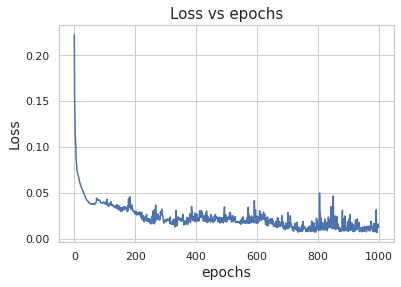

In [0]:
plt.plot(range(epochs),epoch_loss_lst)
plt.xlabel('epochs',{'fontsize':14})
plt.ylabel('Loss',{'fontsize':14})
plt.title('Loss vs epochs',{'fontsize':15})
plt.show()

####TEST

In [0]:
def acc_2(test_data):
  accuracy = 0
  case = 0
  with torch.no_grad():
    if test_data == True:
      data = test
    else:
      data = train    
    for image, label in data:
      for i in range(len(image)):
        case+=1
        img = image[i].view(-1,1,200,200)
        if G == True: img = img.type(torch.FloatTensor).to(device)
        else: img = img.type(torch.FloatTensor)
        output = net.forward(img,flag=False)
        pred = int(torch.argmax(output))
        true = int(torch.argmax(label[i]))
        if pred == 0 and true == 0:
          accuracy+=1
        if pred == 1 and true == 1:
          accuracy+=1
        if pred == 2 and true == 2:
          accuracy+=1       

  accuracy = accuracy/case
  return accuracy

In [0]:
print('accuracy for training dataset:','\n',acc_2(False))
print('accuracy for testing dataset:','\n',acc_2(True))

accuracy for training dataset: 
 0.9604267963263101
accuracy for testing dataset: 
 0.8314424635332253
